# Cardiovascular Disease Prediction

## What are cardiovascular diseases?

Cardiovascular diseases (CVDs) are a group of disorders of the heart and blood vessels and they include:

 - coronary heart disease – disease of the blood vessels supplying the heart muscle;
 - cerebrovascular disease – disease of the blood vessels supplying the brain;
 - peripheral arterial disease – disease of blood vessels supplying the arms and legs;
 - rheumatic heart disease – damage to the heart muscle and heart valves from rheumatic fever, caused by streptococcal bacteria;
 - congenital heart disease – malformations of heart structure existing at birth;
 - deep vein thrombosis and pulmonary embolism – blood clots in the leg veins, which can dislodge and move to the heart and lungs.

Heart attacks and strokes are usually acute events and are mainly caused by a blockage that prevents blood from flowing to the heart or brain. The most common reason for this is a build-up of fatty deposits on the inner walls of the blood vessels that supply the heart or brain. Strokes can also be caused by bleeding from a blood vessel in the brain or from blood clots. The cause of heart attacks and strokes are usually the presence of a combination of risk factors, such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol, hypertension, diabetes and hyperlipidaemia.


### Key facts

 - CVDs are the number 1 cause of death globally: more people die annually from CVDs than from any other cause.
 - An estimated 17.9 million people died from CVDs in 2016, representing 31% of all global deaths. Of these deaths, 85% are due to heart attack and stroke.
 - Over three quarters of CVD deaths take place in low- and middle-income countries.
 - Out of the 17 million premature deaths (under the age of 70) due to noncommunicable diseases in 2015, 82% are in low- and middle-income countries, and 37% are caused by CVDs.
 - Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.
 - People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management using counselling and medicines, as appropriate.
  

## What are the risk factors for cardiovascular disease?

The most important behavioural risk factors of heart disease and stroke are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects of behavioural risk factors may show up in individuals as raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity. These “intermediate risks factors” can be measured in primary care facilities and indicate an increased risk of developing a heart attack, stroke, heart failure and other complications.

Cessation of tobacco use, reduction of salt in the diet, consuming fruits and vegetables, regular physical activity and avoiding harmful use of alcohol have been shown to reduce the risk of cardiovascular disease. In addition, drug treatment of diabetes, hypertension and high blood lipids may be necessary to reduce cardiovascular risk and prevent heart attacks and strokes. Health policies that create conducive environments for making healthy choices affordable and available are essential for motivating people to adopt and sustain healthy behaviour.

There are also a number of underlying determinants of CVDs or "the causes of the causes". These are a reflection of the major forces driving social, economic and cultural change – globalization, urbanization and population ageing. Other determinants of CVDs include poverty, stress and hereditary factors.

# 0.0 Imports

In [1]:
# Data Manipulation
import numpy  as np
import pandas as pd

# Exploratory Data Analyses
import seaborn    as sns
import statistics as st
from matplotlib   import pyplot as plt
from scipy.stats  import pointbiserialr, chi2_contingency

# Data Preprocessing
from sklearn.preprocessing import RobustScaler

# Feature Selection
from boruta           import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.combine        import SMOTETomek
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier

# metrics
from random          import choices as rchoice
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, roc_curve
from sklearn.metrics import precision_recall_curve, classification_report, brier_score_loss

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 

# confusion matrix
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#fine tuning
from numpy                   import argmax
from skopt                   import BayesSearchCV
from sklearn.model_selection import GridSearchCV

# calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# general use
import pickle
import warnings
import random as rnd

# Display
from IPython.core.display import HTML
from IPython.display      import Image

# Filter Warnings
warnings.filterwarnings('ignore')

## 0.1 Functions

In [38]:
###########################################################################################################################

# Descripite Statistics of a Data Frame
def descriptive( df ):
    # Central Tendency - mean, median, mode 
    ct1 = pd.DataFrame( df.apply( np.mean) ).T
    ct2 = pd.DataFrame( df.apply( np.median) ).T
    ct3 = pd.DataFrame( df.apply( st.mode ) ).T 
    
    # Dispersion
    d1 = pd.DataFrame( df.apply( np.std) ).T
    d2 = pd.DataFrame( df.apply( min) ).T
    d3 = pd.DataFrame( df.apply( max) ).T
    d4 = pd.DataFrame( df.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( df.apply(lambda x: np.quantile(x, .25))).T
    d6 = pd.DataFrame( df.apply(lambda x: np.quantile(x, .75))).T
    d7 = pd.DataFrame( df.apply( lambda x: x.skew() ) ).T
    d8 = pd.DataFrame( df.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate
    ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4, d5, d6, d7, d8]).T.reset_index()
    ds.columns = ['attributes', 'mean', 'median', 'mode', 'std', 'min', 'max', 'q1', 'q3', 'range', 'skewness', 'kurtosis']
    return ds

###########################################################################################################################

# Quantiles of Boxplot
def boxqt(df):
    Q1 = np.quantile(df, .25)
    Q2 = np.quantile(df, .50)
    Q3 = np.quantile(df, .75)
    interquartile = Q3 - Q1

    # calculate lower and upper fence 
    lower_fence = Q1 - (1.5 * interquartile)
    upper_fence = Q3 + (1.5 * interquartile)
    return print(f'{df.name} Lower fence is {lower_fence}, Q1 is {Q1}, Q2 is {Q2}, Q3 is {Q3}, Upper Fence is {upper_fence}, Interquartile is {interquartile}')

###########################################################################################################################

# Cramer's V (statistic for categorial-categorial association)
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


###########################################################################################################################

# Feature Selection
def feature_selection(model, X, y,):
    model.fit(X, y)
        
    # Feature importance data frame
    feat_imp = pd.DataFrame({'feature': X.columns,
                             'feature_importance': model.feature_importances_}) \
                             .sort_values('feature_importance', ascending=False) \
                             .reset_index(drop=True)
        
    # Plot feature importance
    plt.figure(figsize=(12,6))
    sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', palette='winter_r')
    plt.title(type(model).__name__, size=16)
    plt.yticks(size=13)
    plt.xticks(size=13)
    plt.xlabel('Feature Importance', size=16, color='grey')
    plt.ylabel('Features', size=16, color='grey')

###########################################################################################################################
    
# Machine Learning Performance
def ml_performance(models, X_train, y_train, X_valid, y_valid, threshold):
    model_df = []     
    for model in models:
        print("Training " + type(model).__name__ + "...")
        model.fit(X_train, y_train)
        
        # predict positive probabilities according to a threshold
        y_proba = model.predict_proba(X_valid)[:, 1]
        y_hat = (y_proba >= threshold).astype(int)
        
        # metrics
        f1 = f1_score(y_valid, y_hat)
        accuracy = accuracy_score(y_valid, y_hat)
        kappa = cohen_kappa_score(y_valid, y_hat)
        roc_auc = roc_auc_score(y_valid, y_hat)
        precision = precision_score(y_valid, y_hat)
        recall = recall_score(y_valid, y_hat)
        brier = brier_score_loss(y_valid, y_hat, pos_label=1)
        
        metrics = pd.DataFrame({'Model Name': type(model).__name__,'Accuracy': accuracy,'Precision': precision,
                                'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc,'Kappa': kappa,
                                'Brier': brier}, index = [0]).sort_values('F1-Score', ascending = False)
        
        model_df.append(metrics)
        final_model = pd.concat(model_df)
    return final_model.sort_values('F1-Score', ascending = False).round(5)

###########################################################################################################################

# Confusion Matrix
def conf_matrix (model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    plot_confusion_matrix(model, X_valid, y_valid, cmap='winter', normalize='true')
    plt.title(type(model).__name__, size = 20)
    plt.xlabel("Predicted label", size=20)
    plt.ylabel("True label", size=20)
    plt.grid(False)

###########################################################################################################################
    
# Cross Validation
def cross_validation(models, X, y, cv):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_df = pd.concat(cv_df)

    return final_df

###########################################################################################################################

# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 25
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()
    
###########################################################################################################################

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data Description

## 1.1 Understanding Variables

Data description source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset?select=cardio_train.csv

There are 3 types of input features:
- Objective - factual information:
    - Age (days);
    - Height (cm);
    - Weight (kg);
    - Gender (binary 1 - women | 2 - men).
    

- Examination - results of medical examination:
    - Systolic blood pressure (ap_hi);
    - Diastolic blood pressure (ap_lo);
    - Cholesterol (cholesterol - 1: normal, 2: above normal, 3: well above normal);
    - Glucose (gluc - 1: normal, 2: above normal, 3: well above normal).
    

- Subjective - information given by the patient:
    - Smoking (smoke - binary);
    - Alcohol intake (alco - binary);
    - Physical Activity (active - binary).
    
    
- Target Variable:
    - Presence or absence of cardiovascular disease (cardio - binary).

## Understanding Blood Pressure, Cholesterol and Glycemia Levels 

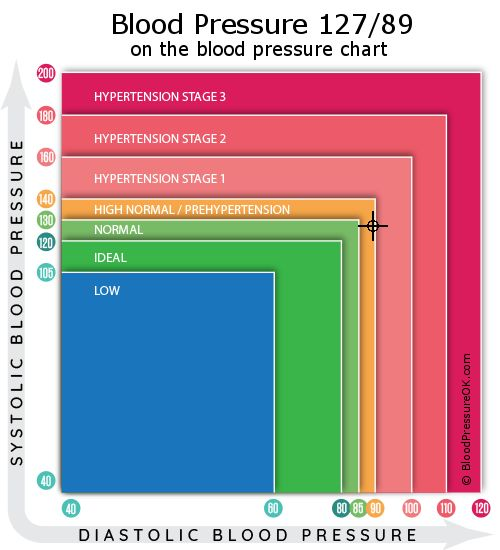

In [248]:
Image('img/bloodpresure.jpg')

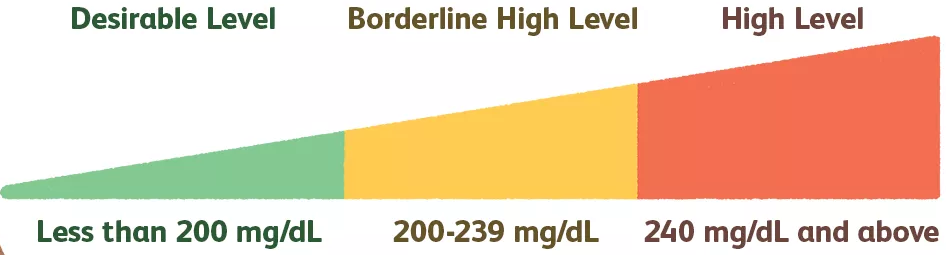

In [249]:
Image('img/cholesterol.png')

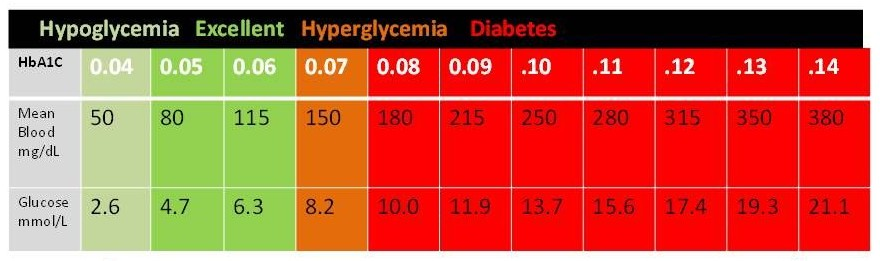

In [250]:
Image('img/glucose.jpg')

## 1.2 Loading Data

In [5]:
df1 = pd.read_csv('cardio_train.csv', sep=';', low_memory=False)
df1.head().T

,0,1,2,3,4
id,0.00000,1.00000,2.00000,3.00000,4.00000
age,18393.00000,20228.00000,18857.00000,17623.00000,17474.00000
gender,2.00000,1.00000,1.00000,2.00000,1.00000
height,168.00000,156.00000,165.00000,169.00000,156.00000
weight,62.00000,85.00000,64.00000,82.00000,56.00000
ap_hi,110.00000,140.00000,130.00000,150.00000,100.00000
ap_lo,80.00000,90.00000,70.00000,100.00000,60.00000
cholesterol,1.00000,3.00000,3.00000,1.00000,1.00000
gluc,1.00000,1.00000,1.00000,1.00000,1.00000
smoke,0.00000,0.00000,0.00000,0.00000,0.00000


## 1.3 Data Dimensions

In [252]:
# Number of Rows and Columns
print('Number of Rows', df1.shape[0])
print('Number of Columns', df1.shape[1])

Number of Rows 70000
Number of Columns 13


## 1.4 Data Info

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## 1.5 Age Convert

In [7]:
# Convert age days in years
df1['age'] = df1['age'] / 365

# Convert do interger 
df1['age'] = df1['age'].astype(int)
df1.head().T

,0,1,2,3,4
id,0.00000,1.00000,2.00000,3.00000,4.00000
age,50.00000,55.00000,51.00000,48.00000,47.00000
gender,2.00000,1.00000,1.00000,2.00000,1.00000
height,168.00000,156.00000,165.00000,169.00000,156.00000
weight,62.00000,85.00000,64.00000,82.00000,56.00000
ap_hi,110.00000,140.00000,130.00000,150.00000,100.00000
ap_lo,80.00000,90.00000,70.00000,100.00000,60.00000
cholesterol,1.00000,3.00000,3.00000,1.00000,1.00000
gluc,1.00000,1.00000,1.00000,1.00000,1.00000
smoke,0.00000,0.00000,0.00000,0.00000,0.00000


In [255]:
# Verification
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## 1.6 Descriptive Statistics

In [256]:
descriptive(df1)

,attributes,mean,median,mode,std,min,max,q1,q3,range,skewness,kurtosis
0,id,49972.419900,50001.5,0.0,28851.096242,0.0,99999.0,99999.0,25006.75,74889.25,-0.001278,-1.198374
1,age,52.840671,53.0,55.0,6.766725,29.0,64.0,35.0,48.00,58.00,-0.305744,-0.818981
2,gender,1.349571,1.0,1.0,0.476835,1.0,2.0,1.0,1.00,2.00,0.630960,-1.601935
3,height,164.359229,165.0,165.0,8.210068,55.0,250.0,195.0,159.00,170.00,-0.642187,7.943653
4,weight,74.205690,72.0,65.0,14.395654,10.0,200.0,190.0,65.00,82.00,1.012070,2.586825
5,ap_hi,128.817286,120.0,120.0,154.010319,-150.0,16020.0,16170.0,120.00,140.00,85.296214,7580.074738
6,ap_lo,96.630414,80.0,80.0,188.471184,-70.0,11000.0,11070.0,80.00,90.00,32.114083,1425.914585
7,cholesterol,1.366871,1.0,1.0,0.680245,1.0,3.0,2.0,1.00,2.00,1.587123,0.993901
8,gluc,1.226457,1.0,1.0,0.572266,1.0,3.0,2.0,1.00,1.00,2.397462,4.294377
9,smoke,0.088129,0.0,0.0,0.283482,0.0,1.0,1.0,0.00,0.00,2.905867,6.444250


### Keys points:

#### - The mean age is 52 years, ranging from 29 to 64

#### - There are more women than men in the dataset

#### - Glucose and cholesterol levels in most people are normal

#### - Most people do not smoke (8,81%) drink alcohol (5,37%) and exercise (80,37%).

#### - Some numerical variables have outliers based on their skewness

   - Height - negative moderately skewed
   - Weight - positive moderated skewed
   - ap_hi, ap_lo - positive high skewed
   
#### There are unrealistic values (outliers) in the dataset as:
 
   - height of 55 cm and 250 cm
   - weight of 10 Kg
   - ap_hi of -150 and 16020
   - ap_lo of -70 and 11000

## 1.7 Outliers

### 1.7.1 Boxplots  with outliers

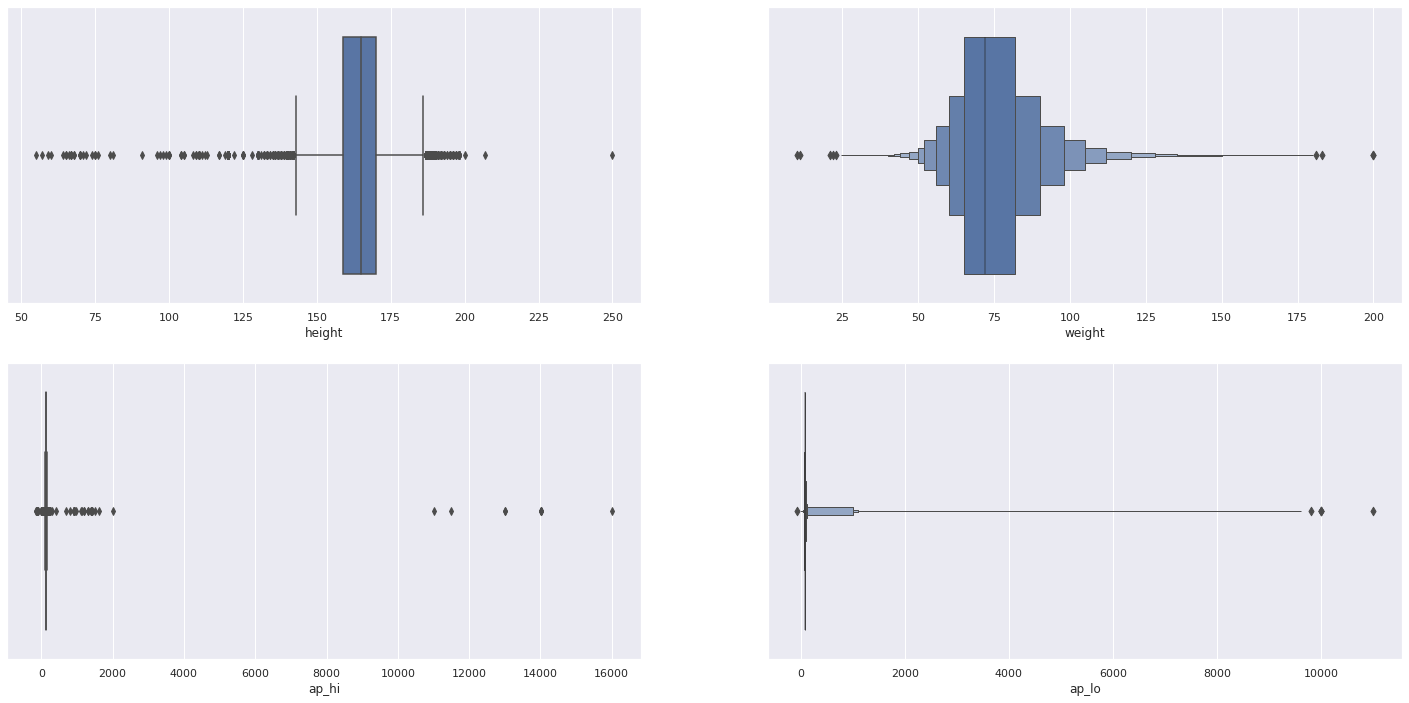

In [8]:
# Boxplot of height
plt.subplot(2,2,1)
sns.boxplot(df1['height'])

# Boxplot of weight
plt.subplot(2,2,2)
sns.boxenplot(df1['weight'])

# Boxplot of ap_hi
plt.subplot(2,2,3)
sns.boxplot(df1['ap_hi'])

# Boxplot of ap_lo
plt.subplot(2,2,4) 
sns.boxenplot(df1['ap_lo']);

### 1.7.2 Boxplots Without Outliers

height Lower fence is 142.5, Q1 is 159.0, Q2 is 165.0, Q3 is 170.0, Upper Fence is 186.5, Interquartile is 11.0
weight Lower fence is 39.5, Q1 is 65.0, Q2 is 72.0, Q3 is 82.0, Upper Fence is 107.5, Interquartile is 17.0
ap_hi Lower fence is 90.0, Q1 is 120.0, Q2 is 120.0, Q3 is 140.0, Upper Fence is 170.0, Interquartile is 20.0
ap_lo Lower fence is 65.0, Q1 is 80.0, Q2 is 80.0, Q3 is 90.0, Upper Fence is 105.0, Interquartile is 10.0


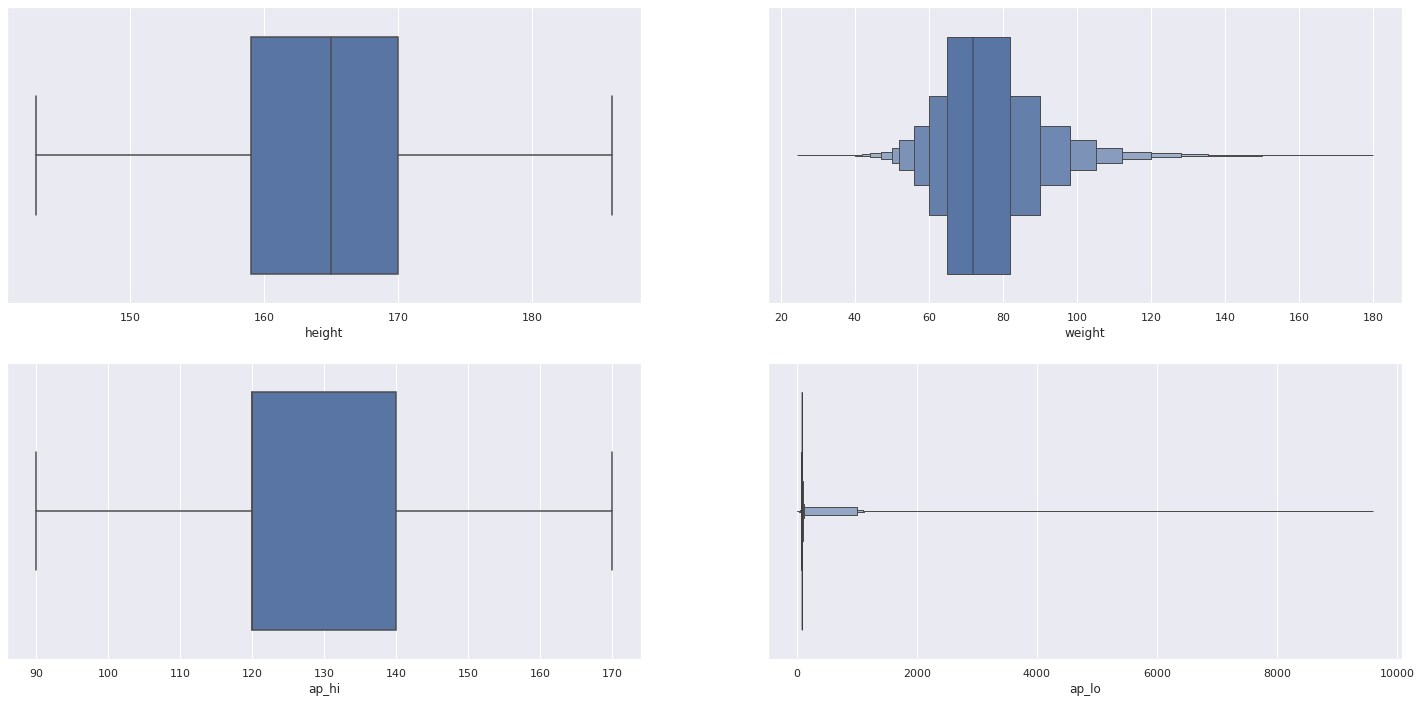

In [37]:
# Boxplot of height
plt.subplot(221)
sns.boxplot(df1['height'], showfliers = False)

# Height
boxqt(df1['height'])

# Boxplot of weight
plt.subplot(222)
sns.boxenplot(df1['weight'], showfliers = False)

# Weight
boxqt(df1['weight'])

# Boxplot of ap_hi
plt.subplot(223)
sns.boxplot(df1['ap_hi'], showfliers = False)

# ap_hi
boxqt(df1['ap_hi'])

# Boxplot of ap_lo
plt.subplot(224) 
sns.boxenplot(df1['ap_lo'], showfliers = False);

# ap_lo
boxqt(df1['ap_lo']);

### 1.7.3 Understanding Individual cases

#### The chart below can be used as a guide to help decide what can be done with outliers

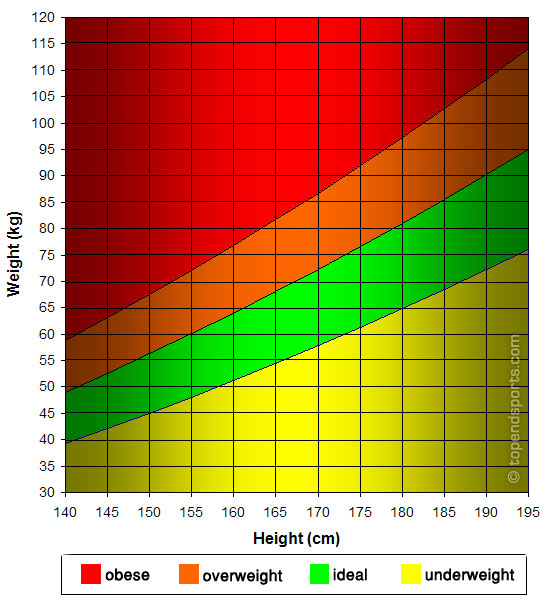

In [263]:
Image("img/wxh.jpg")

#### 1.7.3.1 Height

In [264]:
aux = df1.sort_values(by=['height'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6486,9223,58,1,250,86.0,140,100,3,1,0,0,1,1
21628,30894,52,2,207,78.0,100,70,1,1,0,1,1,0
41901,59847,52,2,200,100.0,170,1100,2,2,0,0,1,1
8897,12687,61,2,198,79.0,160,100,1,1,1,0,0,1
30127,43083,63,1,198,85.0,110,90,1,1,0,0,1,0
1117,1554,60,2,198,68.0,120,80,1,1,0,0,1,1
57529,82105,51,2,198,78.0,120,80,1,1,1,0,1,1
54289,77425,58,2,198,110.0,140,80,2,3,0,0,1,1
66145,94422,61,1,198,80.0,140,90,1,2,0,0,1,1
3237,4561,44,2,198,61.0,110,70,1,1,0,0,1,1


Based on the literature it is unlikely that someone with gigantism and a height of 2,50 m only has 86Kg. The other cases can be acceptable.

In [265]:
aux = df1.sort_values(by=['height'], ascending=True).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,32456,64,1,55,81.0,130,90,1,1,0,0,1,1
66643,95141,51,1,57,61.0,130,90,1,1,0,0,1,1
64115,91523,50,1,59,57.6,125,67,1,1,0,0,0,0
29157,41661,52,1,60,69.0,110,70,1,1,0,0,0,0
27603,39462,57,1,64,61.0,130,70,1,1,0,0,1,0
44490,63545,52,1,65,60.0,120,80,1,1,0,0,1,0
33607,48009,53,2,65,72.0,130,80,1,1,0,0,0,0
64454,92008,58,1,66,63.0,12,80,1,1,0,0,0,1
14323,20459,60,1,67,57.0,120,90,1,1,0,0,1,1
53344,76116,56,2,67,80.0,120,80,1,1,0,0,0,1


The smallest patients are the height of a child, but the age range is 29 to 64 years. Even people with dwarfism have a minimum average height range of 1,20m to 1,40 m.

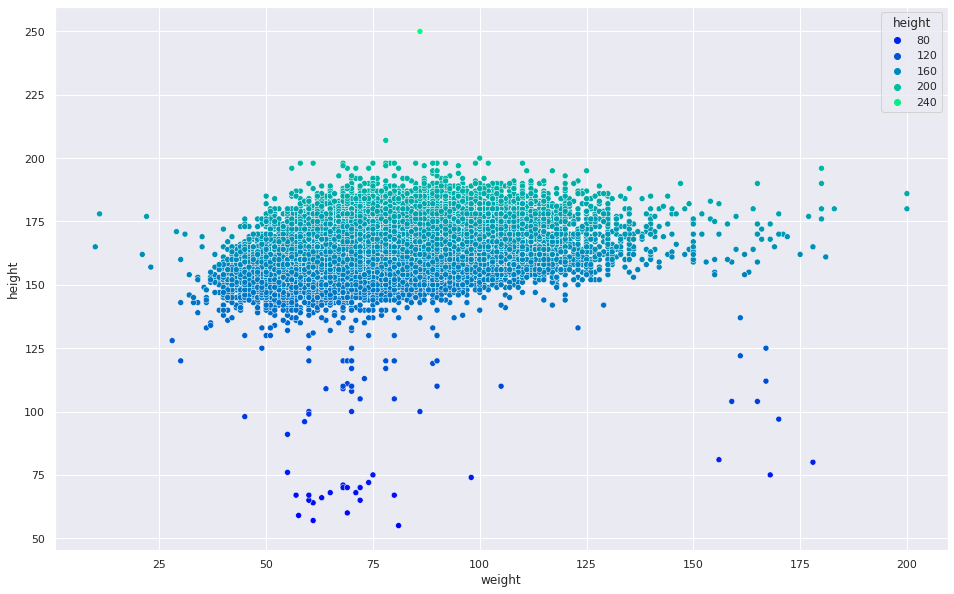

In [266]:
plt.figure(figsize = (16,10))
sns.scatterplot(data = df1, x = 'weight', y = 'height', hue='height', palette = 'winter');

The graph shows very unlikely cases. For instance, a person with a height of 75 cm and a weight of 170 Kg.

#### Based on previous analyzes, it was decided to remove the patient with a height of 2,50m and patients below 1,20m.

In [267]:
# Apply Mean to Height Outliers
df1 = df1[~(df1['height'] == 250)]
df1 = df1[~(df1['height'] < 120)]

#### 1.7.3.2 Weight

In [268]:
aux = df1.sort_values(by=['weight'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
435,618,45,1,186,200.0,130,70,1,1,0,0,0,0
50413,71945,41,2,180,200.0,150,90,1,1,0,0,1,1
61285,87498,57,2,180,183.0,110,80,3,3,0,1,1,1
36780,52564,53,1,161,181.0,180,1100,2,1,0,0,1,1
60592,86506,51,2,180,180.0,140,100,3,1,0,0,1,1
4743,6716,47,2,176,180.0,140,90,1,1,0,0,1,1
45378,64829,47,2,190,180.0,140,80,2,2,0,0,1,1
61362,87612,45,2,196,180.0,130,80,3,1,0,0,1,1
61788,88220,51,2,165,178.0,120,80,1,1,0,0,1,0
20092,28683,56,2,165,178.0,120,80,1,1,1,1,1,0


Based on the literature it is possible for people to weigh 200kg.

In [269]:
aux = df1.sort_values(by=['weight'], ascending=True).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57858,82567,51,2,165,10.0,180,1100,2,2,0,0,1,1
33817,48318,59,2,178,11.0,130,90,1,1,0,0,1,1
60188,85931,59,1,162,21.0,120,80,2,1,0,0,1,1
29488,42156,55,2,177,22.0,120,80,1,1,1,1,1,0
26806,38312,63,1,157,23.0,110,80,1,1,0,0,1,0
34276,48976,40,2,128,28.0,120,80,1,1,0,0,1,0
60699,86650,51,1,171,29.0,110,70,2,1,0,0,1,1
3752,5306,42,1,120,30.0,110,70,1,1,0,0,1,0
18559,26503,49,1,160,30.0,120,80,1,1,0,0,1,1
41905,59853,58,1,143,30.0,103,61,2,1,0,0,1,0


Based on the literature it is unlikely for some people to weigh below 23kg.

#### Based on the previous analyses it was decided to remove weights below 23kg.

In [270]:
# Apply Mean to Weight Outliers
df1= df1[~(df1['weight'] < 23)]

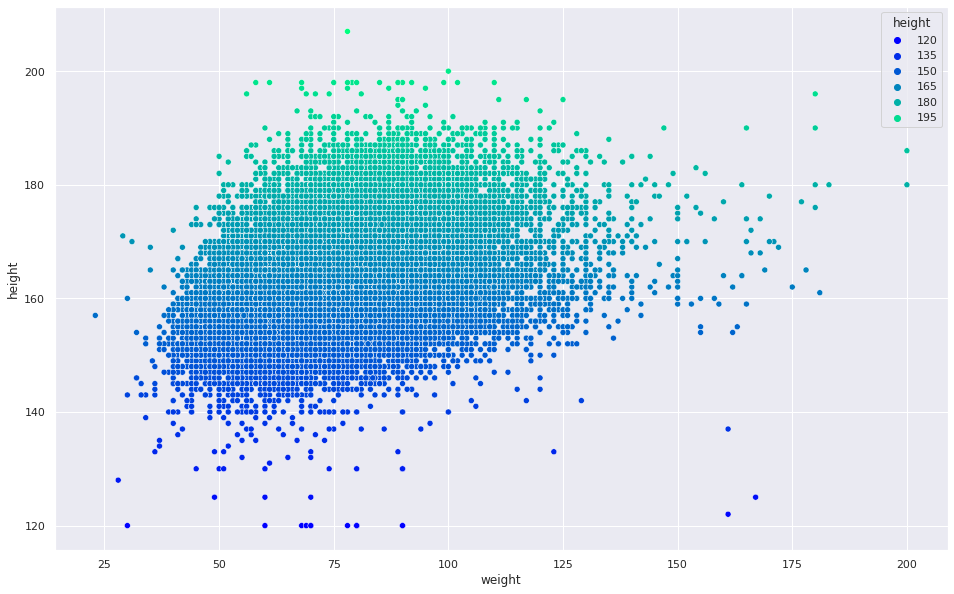

In [271]:
# Scatterplot after weight and height outliers treatment
plt.figure(figsize = (16,10))
sns.scatterplot(data = df1, x = 'weight', y = 'height', hue='height', palette = 'winter');

Analyzing the graph again the cuts that were made are noticeable, but it seems to be much more reasonable now. 

#### 1.7.3.3 ap_lo (Diastolic Blood Presure)

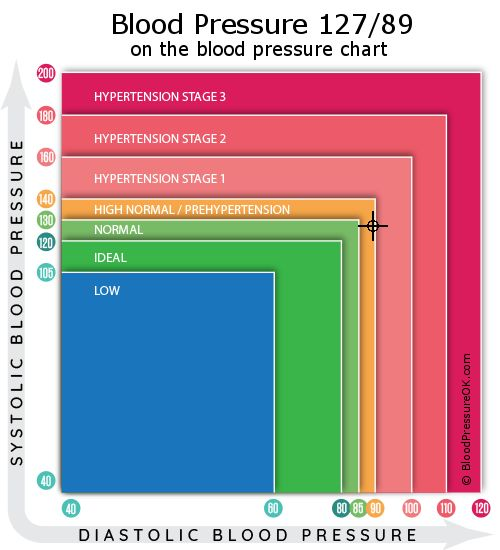

In [272]:
Image('img/bloodpresure.jpg')

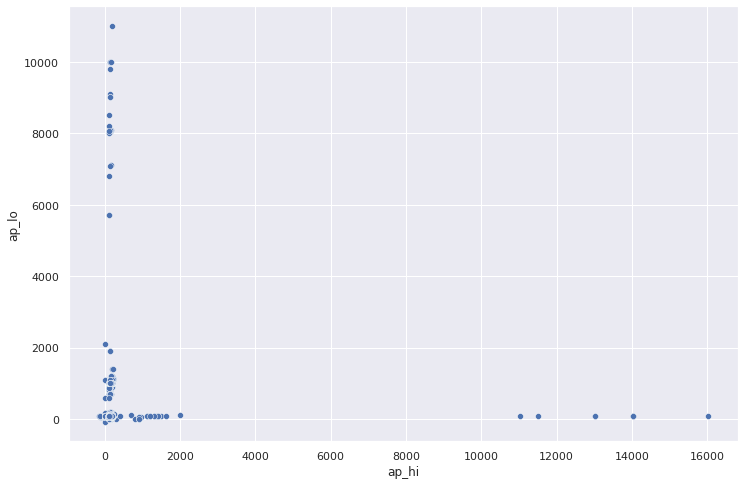

In [273]:
# Scatterplot of ap_li and ap_lo 
plt.figure(figsize = (12,8))
sns.scatterplot(data = df1, x = 'ap_hi', y = 'ap_lo');

In [274]:
aux = df1.sort_values(by=['ap_lo'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
43326,61901,63,1,160,105.0,200,11000,1,1,0,0,1,1
23849,34098,49,2,169,86.0,150,10000,2,2,0,1,1,1
68538,97907,52,1,166,70.0,160,10000,2,1,0,0,1,1
2381,3352,57,2,186,105.0,140,10000,1,1,0,0,1,1
43434,62058,60,2,179,62.0,130,9800,1,1,0,0,1,0
6653,9482,53,1,162,69.0,130,9100,1,1,0,0,1,1
12086,17260,58,2,169,78.0,130,9011,1,1,1,1,1,1
32920,47030,50,1,156,65.0,150,9011,2,2,0,0,1,1
15990,22832,39,2,179,70.0,120,8500,1,1,0,0,1,0
44042,62921,58,1,165,74.0,120,8200,2,3,0,0,1,0


As can be seen many patients have impossible number for blood pressure 

In [275]:
aux = df1.sort_values(by=['ap_lo'], ascending=True).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,61,1,167,74.0,15,-70,1,1,0,0,1,1
2014,2845,62,2,167,59.0,906,0,1,1,0,0,1,0
16459,23512,56,1,156,50.0,138,0,3,1,0,0,1,1
52580,75007,60,1,155,66.0,13,0,1,1,0,0,1,0
27686,39577,64,2,180,73.0,140,0,1,1,1,1,1,1
68663,98095,49,1,156,41.0,906,0,1,1,0,0,1,0
38370,54780,63,2,170,81.0,148,0,1,1,0,0,1,0
22923,32749,58,2,166,68.0,149,0,1,1,0,0,1,1
43922,62754,51,1,164,78.0,108,0,2,1,0,0,1,0
17381,24837,49,1,164,78.0,138,0,1,1,0,0,1,0


The same can be seen here

#### Based on the literature it was decided to remove the values higher than 120 and lower than 40.

In [276]:
# Apply Mean to ap_lo Outliers
df1 = df1[~(df1['ap_lo'] > 120)] 
df1 = df1[~(df1['ap_lo'] < 40)] 

#### 1.7.3.4 ap_hi (Systolic Blood Presure)

In [277]:
aux = df1.sort_values(by=['ap_hi'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40852,58374,47,1,169,70.0,16020,80,1,1,0,0,0,1
47253,67502,54,1,160,65.0,14020,90,1,1,0,0,1,0
25519,36414,58,1,169,71.0,14020,80,3,3,0,0,1,1
25464,36339,43,2,169,75.0,14020,80,2,1,0,0,1,1
46912,66998,46,2,180,78.0,14020,90,1,1,0,0,1,1
55847,79679,63,1,161,105.0,13010,80,1,1,0,0,0,0
55459,79116,50,1,152,76.0,13010,80,2,2,0,0,1,1
7763,11089,57,1,175,80.0,11500,90,1,1,0,0,1,1
51438,73356,51,2,168,65.0,11020,80,1,1,0,0,1,1
69370,99089,40,1,170,74.0,2000,100,2,1,0,0,1,1


The highest values are impossible numbers

In [278]:
aux = df1.sort_values(by=['ap_hi'], ascending=True).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35040,50055,63,2,168,59.0,-150,80,1,1,0,0,1,1
23988,34295,50,1,162,74.0,-140,90,1,1,0,0,1,1
46627,66571,64,2,160,59.0,-120,80,1,1,0,0,0,0
25240,36025,40,2,168,50.0,-120,80,2,1,0,0,0,1
16021,22881,60,2,161,90.0,-115,70,1,1,0,0,1,0
4607,6525,41,1,165,78.0,-100,80,2,1,0,0,1,0
20536,29313,42,1,153,54.0,-100,70,1,1,0,0,1,0
5382,7657,58,1,162,69.0,7,80,1,1,0,0,1,0
2612,3683,64,1,170,64.0,10,70,1,1,0,0,1,1
57909,82646,44,1,165,56.0,10,60,1,1,0,0,1,0


The lowest values are impossible numbers too

#### Based on the literature it was decided to remove the values higher than 200 and lower than 40.

In [279]:
# Apply Mean to ap_lo Outliers
df1 = df1[~(df1['ap_hi'] > 200)]
df1 = df1[~(df1['ap_hi'] < 40)]

#### Scatter plot after processing

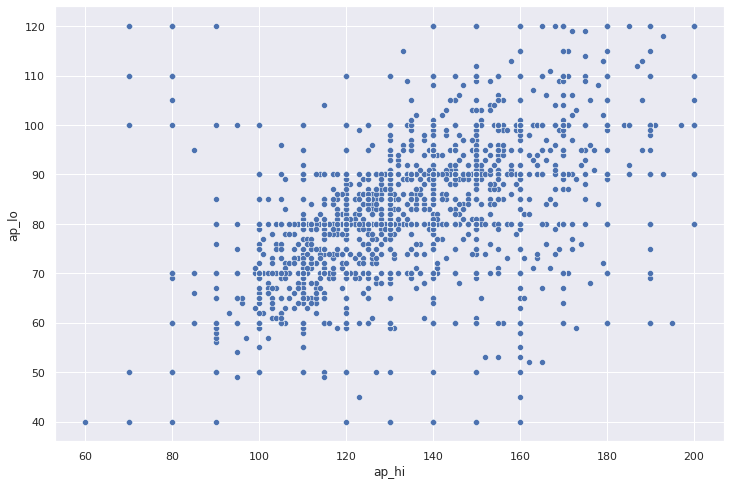

In [280]:
# Scatterplot of ap_li and ap_lo 
plt.figure(figsize = (12,8))
sns.scatterplot(data = df1, x = 'ap_hi', y = 'ap_lo');

The graph now is much more reasonable

In [281]:
# Percentage of outliers removed from the dataset
print('{:.2f}% of the data was removed'.format((100 - (df1.shape[0]/70000)*100)))

2.02% of the data was removed


# 2.0 Feature Engineering

## 2.1 Hypothesis Mental Map

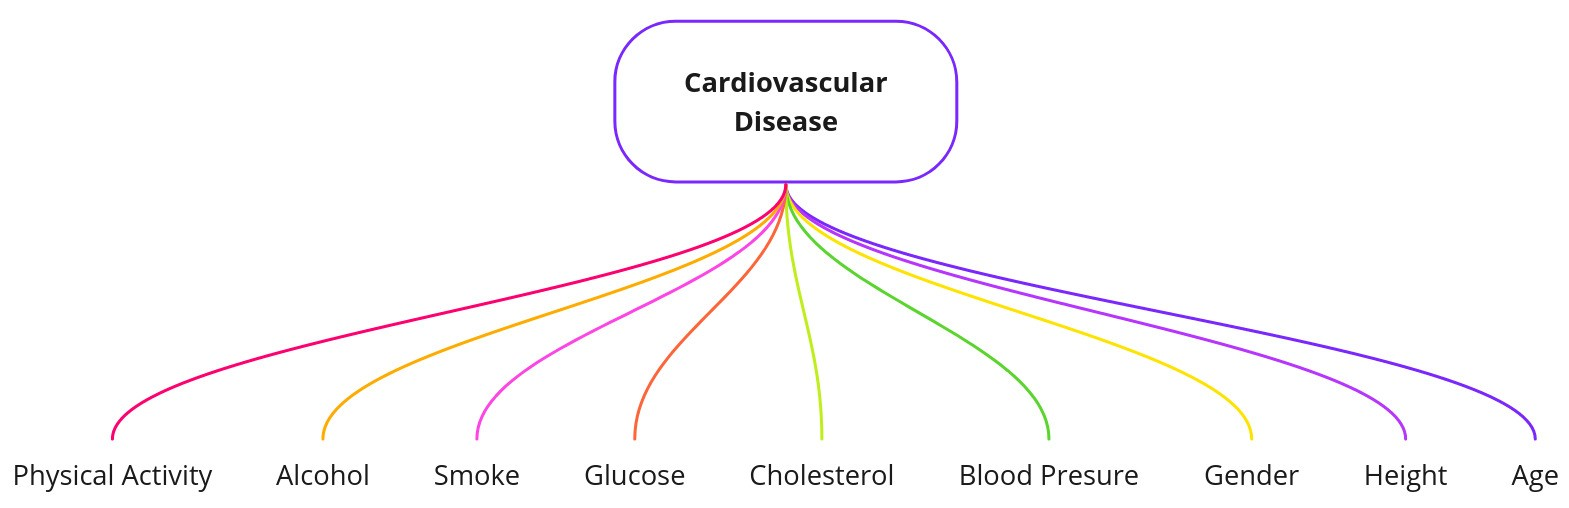

In [282]:
Image('img/mindmap.jpg')

## 2.2 Hypothesis List

### Based on the literature we can make the follow hypothesis:

### H1 - Older people have more cardiovascular diseases

### H2 - Smaller people have more cardiovascular diseases

### H3 - Men have more cardiovascular diseasess

### H4 - People with higher blood pressure have more cardiovascular diseases

### H5 - People with higher cholesterol have more cardiovascular diseases

### H6 - People with higher glucose have more cardiovascular diseases

### H7 - People who smoke have more cardiovascular diseases

### H8 - People who drink alcohol have more cardiovascular diseases

### H9 - Sedentary people have more cardiovascular diseasess

### Based on the hypothesis list some features can be created as BMI index, blood pressure aggregating ap_hi and ap_lo and a risk scale. Now we can add 2 more hypothesis.

### H10 - People with higher BMI have more cardiovascular diseases

### H11 - People with higher Risk Scale of CVD have more cardiovascular diseases

## 2.3 BMI

#### Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. 
#### BMI is an easy screening method for weight category—underweight, healthy weight, overweight, and obesity.

| BMI             | Weight Status           |
|-----------------|-------------------------|
| Below 18.5      | Underweight             |
| 18.5 - 24.9     | Normal or Health weight |
| 25.0 - 29.9     | Overweight              |
| 30.0 and above  | Obese                   |

In [283]:
df2 = df1.copy()

In [284]:
# Create a BMI Variable
df2['bmi'] = (df2['weight'] / ((df2['height']/100)**2)).round(1)

In [285]:
# Create a BMI Status Variable
df2['bmi_status'] = df2['bmi'].apply(lambda x: 'underweight' if x < 18.5 
                                             else 'normal' if (x >= 18.5) & (x <= 29.4)
                                             else 'overweight' if (x >= 25) & (x <= 29.9)
                                             else 'obese')

## 2.4 Blood Pressure

In [286]:
# Create Blod Pressure Variable
df2['blood_pressure'] = ['0' if (ap_hi <= 105) & (ap_lo <= 60)
                               else '1' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else '2' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else '3' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else '4' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else '5' 
                               for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]

In [287]:
# Create Blod Pressure Status Variable
df2['blood_pressure_status'] = ['low' if (ap_hi <= 105) & (ap_lo <= 60)
                               else 'normal' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else 'high_normal' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else 'hypertension_1' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else 'hypertension_2' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else 'hypertension_3' 
                               for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]

## 2.5 Risk Scale

### The Risk Scale gives a summary of important varibales that can predict CVD based on the literature. This variables are: glucucose, cholesterol, bmi, somking, alcohol consumption and pshysical activity.

In [288]:
# Creating Risk Scale Variable rangind from 0 to 1
df2['risk_scale'] = df2['gluc'] + df2['cholesterol'] + df2['bmi'] + df2['smoke'] + df2['alco'] + df2['active']

In [289]:
df2.describe().T 

,count,mean,std,min,25%,50%,75%,max
id,68583.0,49972.437572,28846.807873,0.0,24999.0,50010.0,74869.5,99999.0
age,68583.0,52.825861,6.770520,29.0,48.0,53.0,58.0,64.0
gender,68583.0,1.348497,0.476498,1.0,1.0,1.0,2.0,2.0
height,68583.0,164.411006,7.913987,120.0,159.0,165.0,170.0,207.0
weight,68583.0,74.096670,14.282790,23.0,65.0,72.0,82.0,200.0
ap_hi,68583.0,126.544596,16.497145,60.0,120.0,120.0,140.0,200.0
ap_lo,68583.0,81.276351,9.350492,40.0,80.0,80.0,90.0,120.0
cholesterol,68583.0,1.364245,0.678599,1.0,1.0,1.0,1.0,3.0
gluc,68583.0,1.225668,0.571610,1.0,1.0,1.0,1.0,3.0
smoke,68583.0,0.087937,0.283206,0.0,0.0,0.0,0.0,1.0


In [290]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68583 entries, 0 to 69999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     68583 non-null  int64  
 1   age                    68583 non-null  int64  
 2   gender                 68583 non-null  int64  
 3   height                 68583 non-null  int64  
 4   weight                 68583 non-null  float64
 5   ap_hi                  68583 non-null  int64  
 6   ap_lo                  68583 non-null  int64  
 7   cholesterol            68583 non-null  int64  
 8   gluc                   68583 non-null  int64  
 9   smoke                  68583 non-null  int64  
 10  alco                   68583 non-null  int64  
 11  active                 68583 non-null  int64  
 12  cardio                 68583 non-null  int64  
 13  bmi                    68583 non-null  float64
 14  bmi_status             68583 non-null  object 
 15  bl

In [291]:
# Trasform blood pressure in int64
df2['blood_pressure'] = df2['blood_pressure'].astype(int64)

In [292]:
# Check
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68583 entries, 0 to 69999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     68583 non-null  int64  
 1   age                    68583 non-null  int64  
 2   gender                 68583 non-null  int64  
 3   height                 68583 non-null  int64  
 4   weight                 68583 non-null  float64
 5   ap_hi                  68583 non-null  int64  
 6   ap_lo                  68583 non-null  int64  
 7   cholesterol            68583 non-null  int64  
 8   gluc                   68583 non-null  int64  
 9   smoke                  68583 non-null  int64  
 10  alco                   68583 non-null  int64  
 11  active                 68583 non-null  int64  
 12  cardio                 68583 non-null  int64  
 13  bmi                    68583 non-null  float64
 14  bmi_status             68583 non-null  object 
 15  bl

# 3.0 Variable Selection

In [293]:
df3 = df2.copy()

### 3.1 Split into numerical, categorical and binary variables

In [347]:
# Divide features in numerical, categorical and binary
num_var = df3[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'risk_scale']]
cat_var = df3[['cholesterol', 'gluc', 'blood_pressure']]
bin_var = df3[['gender', 'smoke', 'alco', 'active']]

# 4.0 Exploratory Data Analysis

In [295]:
df4 = df3.copy()

## 4.1 Descriptive Statistics after preprocessing

In [296]:
# Numerical variables statistics
descriptive(num_var)

,attributes,mean,median,mode,std,min,max,q1,q3,range,skewness,kurtosis
0,age,52.825861,53.0,55.0,6.770471,29.0,64.0,35.0,48.0,58.0,-0.304099,-0.821671
1,height,164.411006,165.0,165.0,7.913930,120.0,207.0,87.0,159.0,170.0,0.022800,0.619040
2,weight,74.096670,72.0,65.0,14.282686,23.0,200.0,177.0,65.0,82.0,0.988848,2.415068
3,ap_hi,126.544596,120.0,120.0,16.497025,60.0,200.0,140.0,120.0,140.0,0.813234,1.275851
4,ap_lo,81.276351,80.0,80.0,9.350424,40.0,120.0,80.0,80.0,90.0,0.235695,1.151526
5,bmi,27.450129,26.3,23.9,5.252774,9.3,108.2,98.9,23.9,30.1,1.343634,4.539086
6,risk_scale,30.984678,29.9,27.2,5.558309,12.3,111.2,98.9,27.0,34.0,1.250310,3.742351


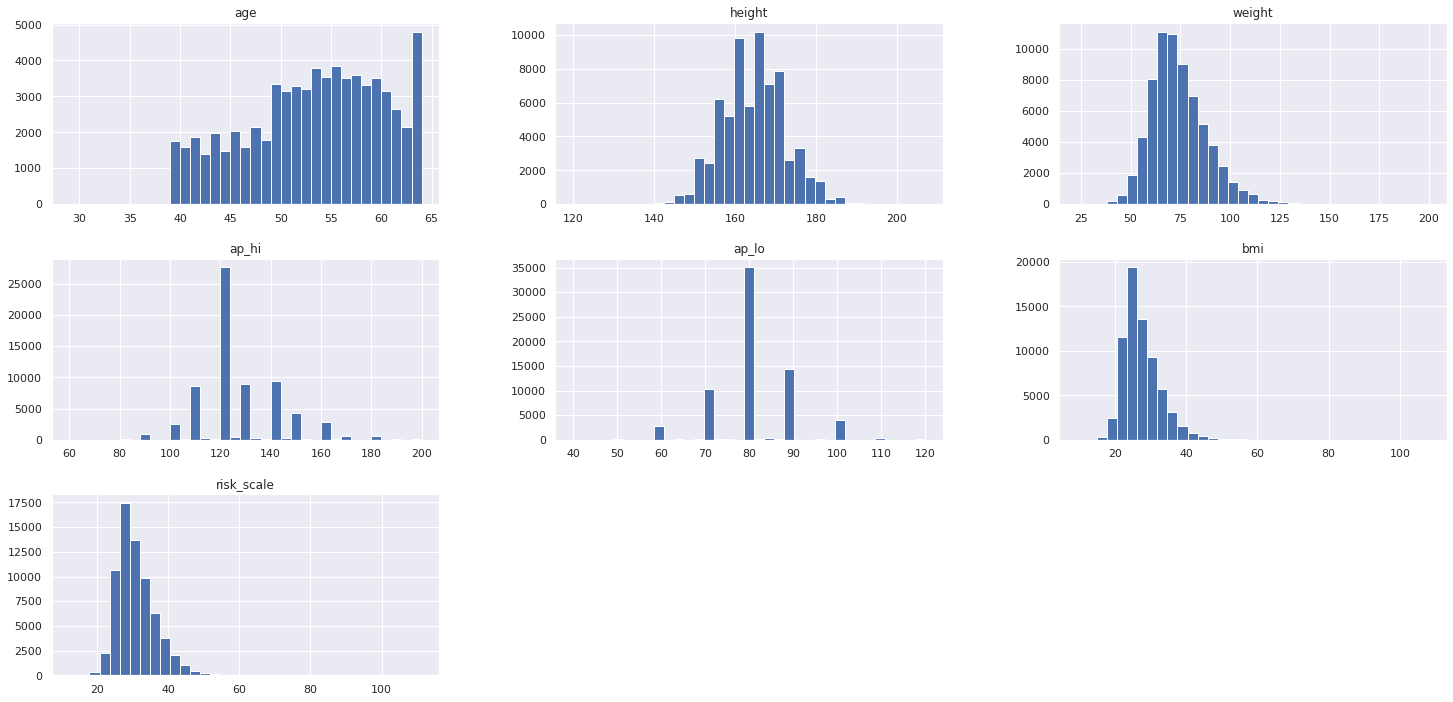

In [297]:
num_var.hist( bins = 35 );

## 4.2 Univariate Analysis

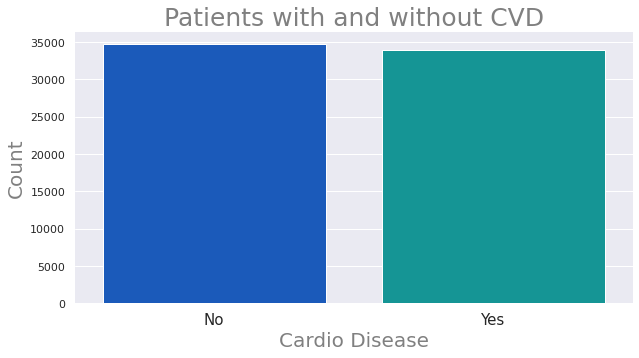

In [298]:
plt.figure(figsize(10,5))
sns.countplot(df1['cardio'], palette='winter')
sns.set_style('whitegrid')
plt.title('Patients with and without CVD', size = 25, color = 'grey')
plt.xlabel('Cardio Disease', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

#### People with and without cardio desease are almost equal (around 35.000).

## 4.3 Bivariate Analysis - Hypothesis Validation

### 4.3.1 H1 - Older people have more cardiovascular disease

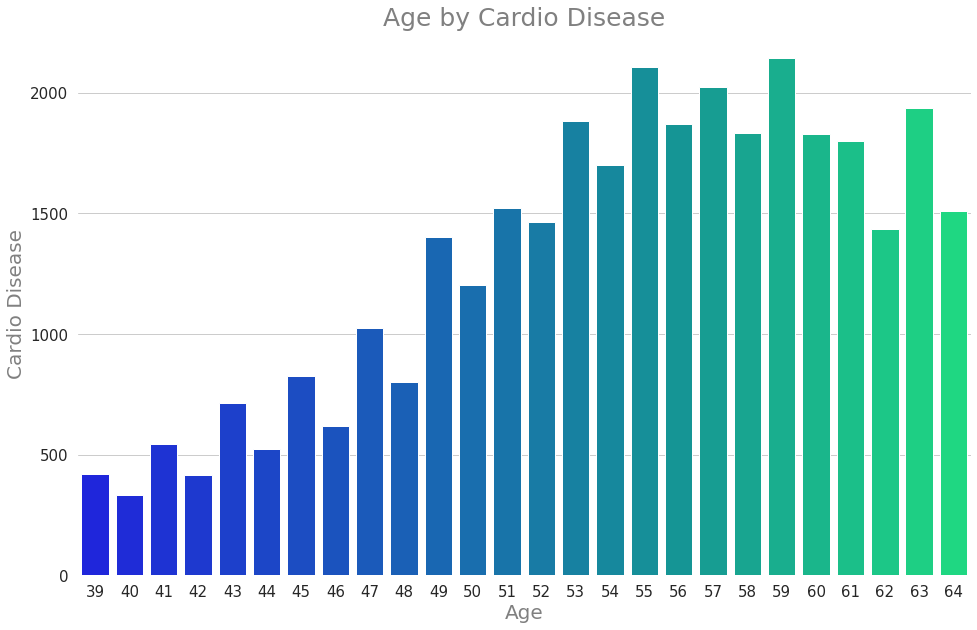

In [299]:
plt.figure(figsize(16,10))
aux = df4[df4['cardio'] == 1 ][['age', 'cardio']].groupby('age').sum().reset_index()
sns.barplot( x = 'age', y = 'cardio', data = aux, palette = 'winter' );
plt.title('Age by Cardio Disease', size = 25, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

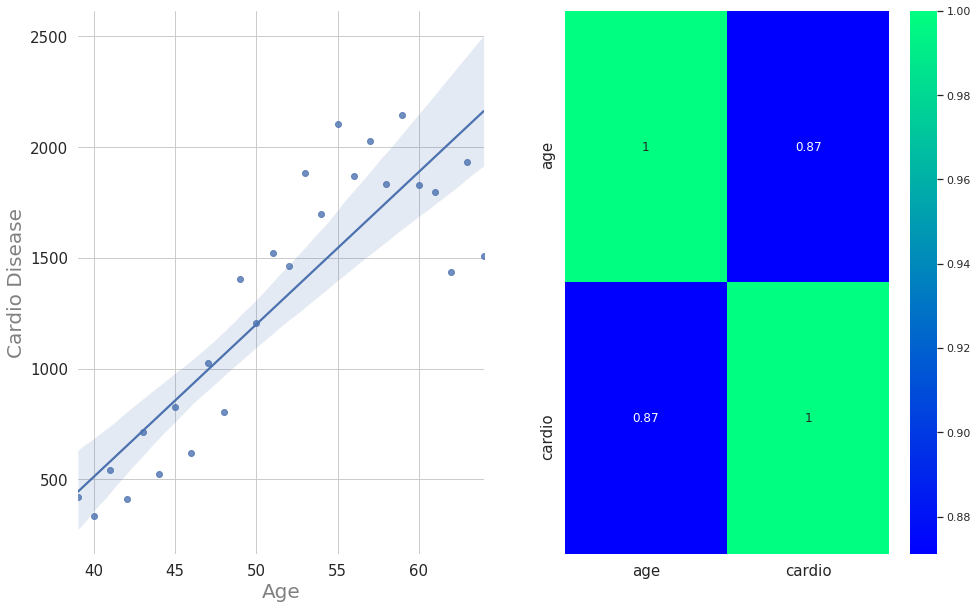

In [300]:
plt.subplot(121)
sns.regplot( x = 'age', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')

plt.subplot(122)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### True hypothesis and the correlation is strong (0.87)

### 4.3.2 H2 - Smaller people have more cardiovascular diseases

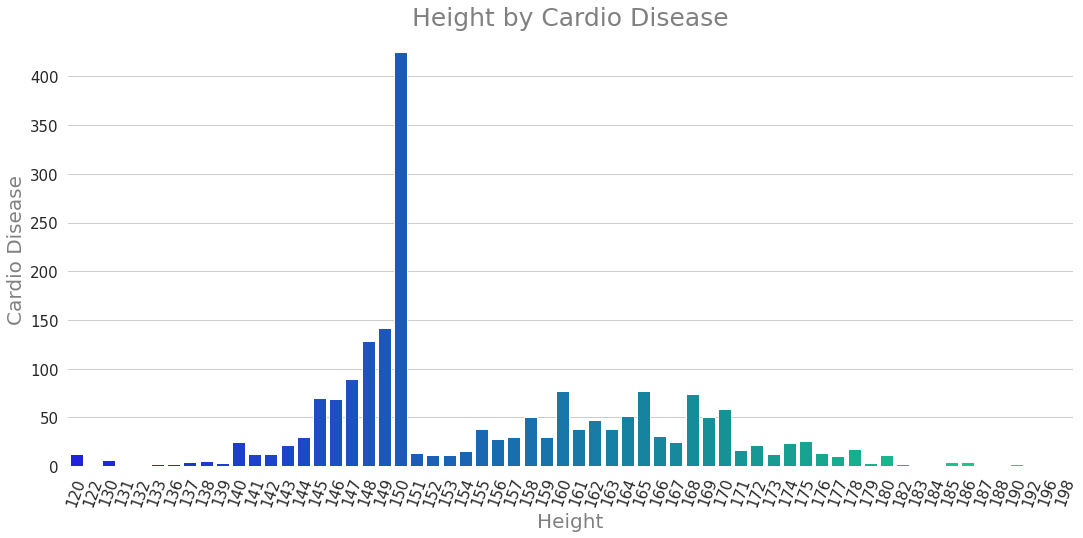

In [301]:
aux1 = df4[df4['height'] <= 150 ].sample(2000, replace=False) 
aux2 = df4[df4['height'] > 150 ].sample(2000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['height', 'cardio']].groupby('height').sum().reset_index()

plt.figure(figsize=(18,8))
sns.barplot( x = 'height', y = 'cardio', data = aux4, palette = 'winter' );
plt.title('Height by Cardio Disease', size = 25, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks( rotation = 70, size = 15 )
plt.yticks(size = 15)
plt.xlabel("Height", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

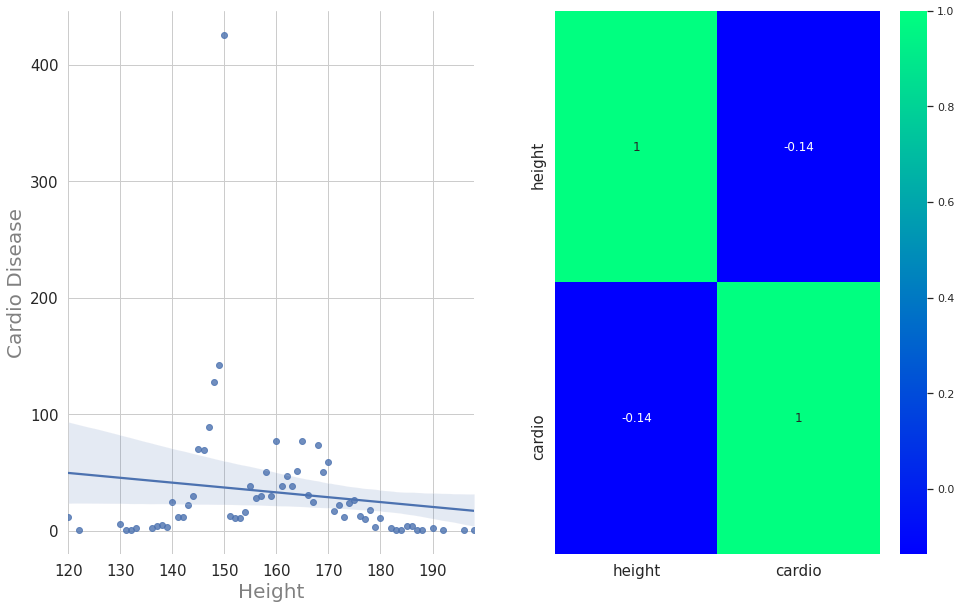

In [302]:
plt.subplot(121)
sns.regplot( x = 'height', y = 'cardio', data = aux4)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Height", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')

plt.subplot(122)
sns.heatmap( aux4.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### True Hypothesis, but the correlation is low (-0.32)

### 4.3.3 H3 - Men have more cardiovascular diseasess

In [303]:
aux1 = df4[df4['gender'] == 1].sample(20000, replace=False) 
aux2 = df4[df4['gender'] == 2].sample(20000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['cardio', 'gender']].groupby(['gender']).sum().reset_index()
aux4

,gender,cardio
0,1,9807
1,2,9957


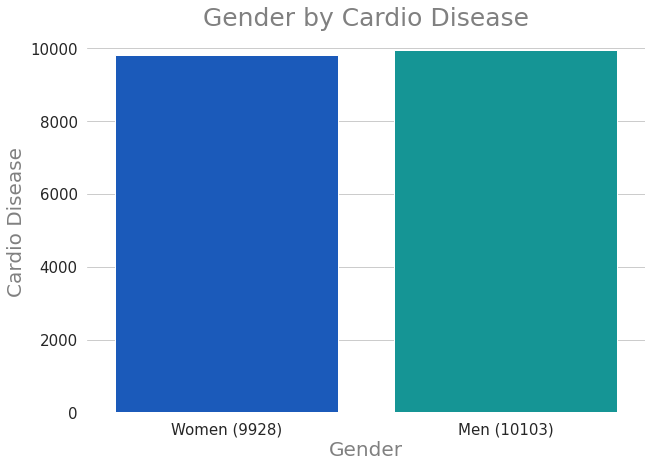

In [304]:
plt.figure(figsize(10,7))
sns.barplot( x = 'gender', y = 'cardio', data = aux4, palette = 'winter' )
plt.title( 'Gender by Cardio Disease', size = 25, color = 'gray')
sns.despine(bottom = True, left = True)
plt.xlabel("Gender", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Women (9928)', 'Men (10103)'], size = 15)
plt.yticks(size = 15);

### True Hypothesis, but the difference is minimal

### 4.3.4 H4 - People with higher blood pressure have more cardiovascular diseases

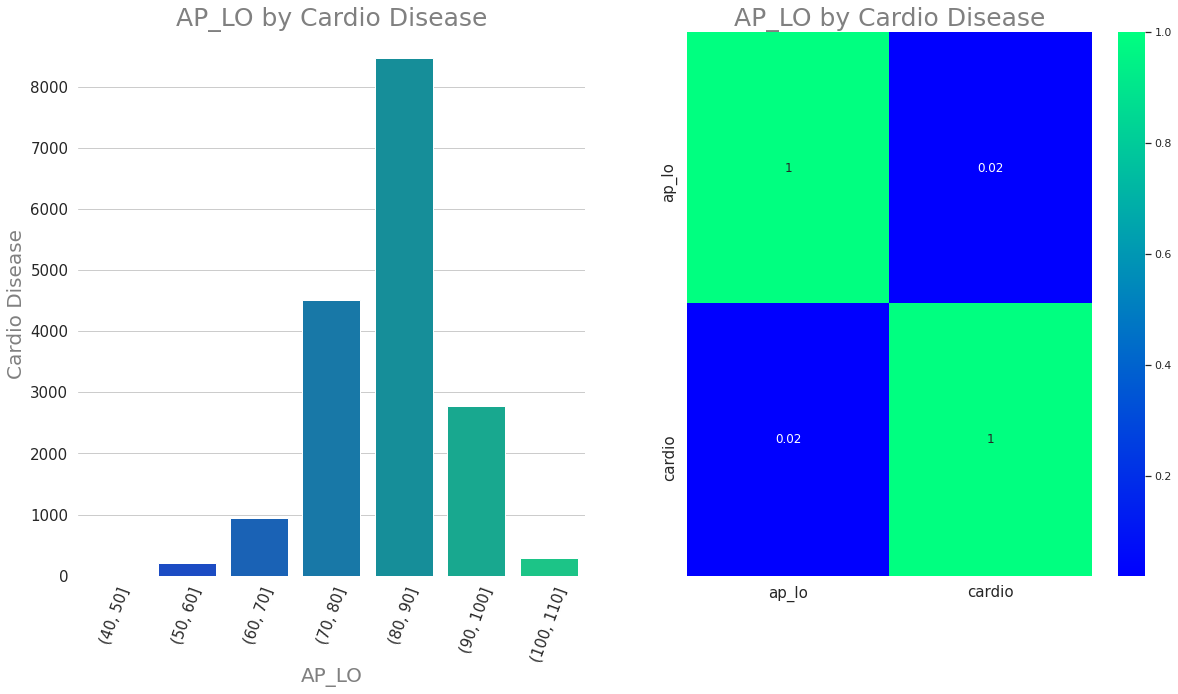

In [305]:
aux1 = df4[df4['ap_lo'] >= 90].sample(15000, replace=False) 
aux2 = df4[df4['ap_lo'] < 90].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_lo']].groupby(['ap_lo']).sum().reset_index()

bins = list( np.arange( 40, 120, 10) )
aux5['ap_lo_binned'] = pd.cut( aux5[ 'ap_lo' ], bins = bins )
aux6 = aux5[['cardio', 'ap_lo_binned']].groupby(['ap_lo_binned']).sum().reset_index()

plt.figure(figsize(20,10))
plt.subplot(121)
sns.barplot( x = 'ap_lo_binned', y = 'cardio', data = aux6, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("AP_LO", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15);

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO by Cardio Disease', size = 25, color = 'gray')
plt.xticks(size = 15)
plt.yticks(size = 15);

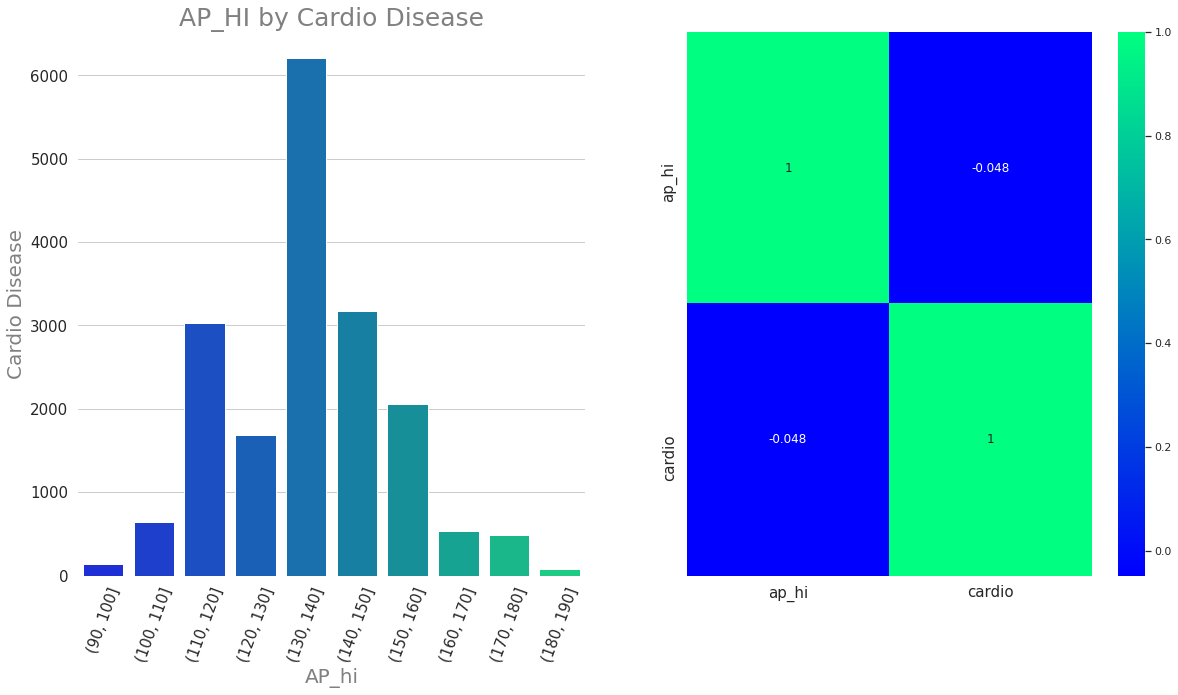

In [306]:
aux1 = df4[df4['ap_hi'] >= 140].sample(15000, replace=False) 
aux2 = df4[df4['ap_hi'] < 140].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_hi']].groupby(['ap_hi']).sum().reset_index()

bins = list( np.arange( 90, 200, 10) )
aux5['ap_hi_binned'] = pd.cut( aux5[ 'ap_hi' ], bins = bins )
aux6 = aux5[['cardio', 'ap_hi_binned']].groupby(['ap_hi_binned']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'ap_hi_binned', y = 'cardio', data = aux6, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_HI by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("AP_hi", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

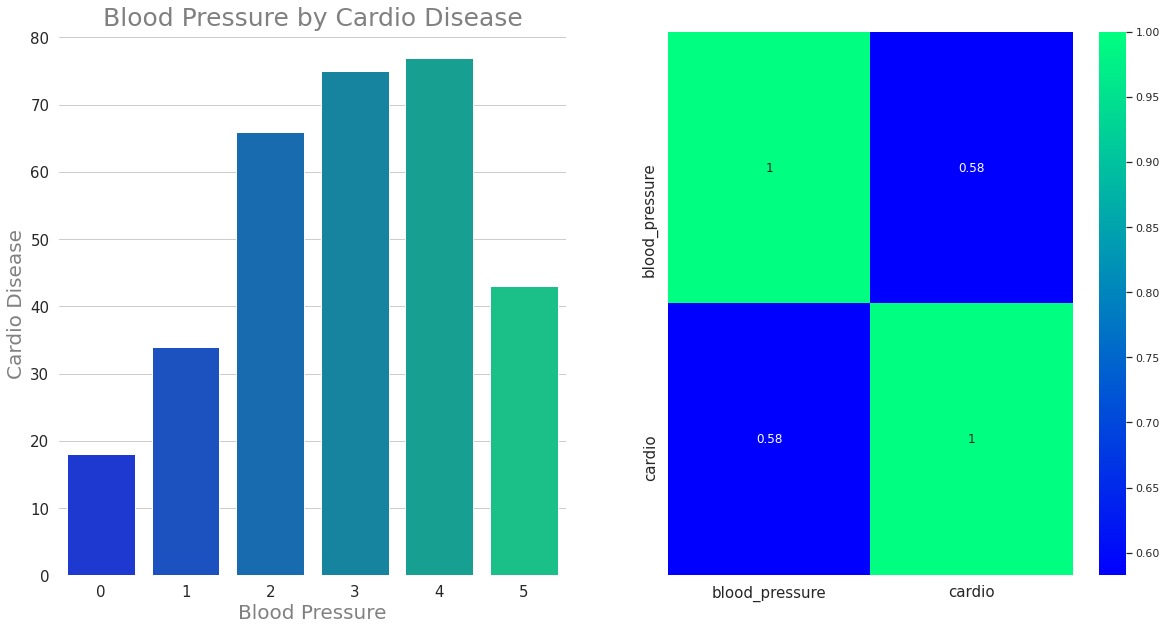

In [307]:
aux1 = df4[df4['blood_pressure'] == 0].sample(100, replace=False) 
aux2 = df4[df4['blood_pressure'] == 1].sample(100, replace=False) 
aux3 = df4[df4['blood_pressure'] == 2].sample(100, replace=False) 
aux4 = df4[df4['blood_pressure'] == 3].sample(100, replace=False) 
aux5 = df4[df4['blood_pressure'] == 4].sample(100, replace=False) 
aux6 = df4[df4['blood_pressure'] == 5].sample(100, replace=False) 

aux7 = pd.concat([aux1, aux2, aux3, aux4, aux5, aux6])
aux8 = aux7[aux7['cardio'] == 1][['cardio', 'blood_pressure']].groupby(['blood_pressure']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'blood_pressure', y = 'cardio', data = aux8, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Blood Pressure by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Blood Pressure", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux8.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### True Hypothesis, the correlation is positive moderate high (0.63)

### 4.3.5 H5 - People with higher cholesterol have more cardiovascular diseases

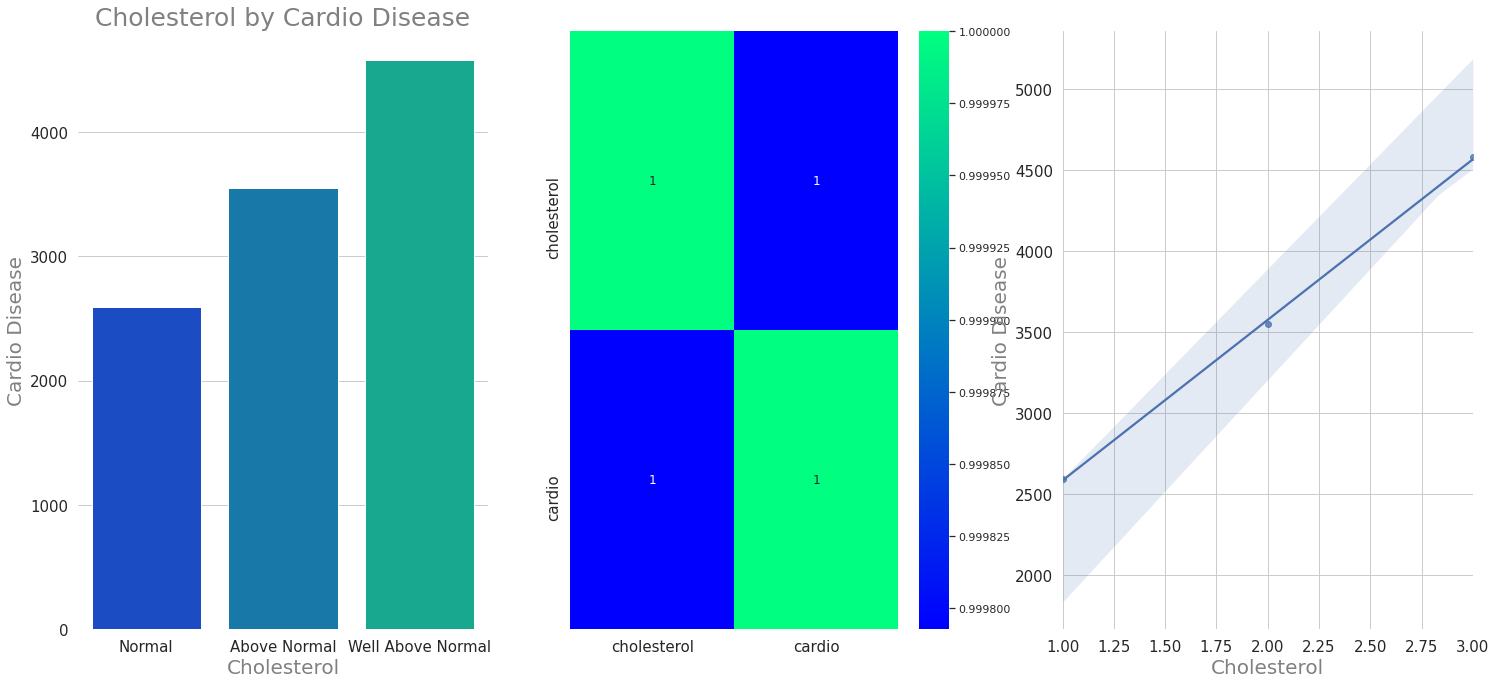

In [308]:
aux1 = df4[df4['cholesterol'] == 1].sample(6000, replace=False)
aux2 = df4[df4['cholesterol'] == 2].sample(6000, replace=False)
aux3 = df4[df4['cholesterol'] == 3].sample(6000, replace=False)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'cholesterol']].groupby(['cholesterol']).sum().reset_index()

plt.figure(figsize(25,11))  
plt.subplot(131)
sns.barplot( x = 'cholesterol', y = 'cardio', data = aux5, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Cholesterol by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Cholesterol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Above Normal', 'Well Above Normal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'cholesterol', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cholesterol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### True Hypothesis, the correlation is perfect (1)

### 4.3.6 H6 - People with higher glucose have more cardiovascular diseases

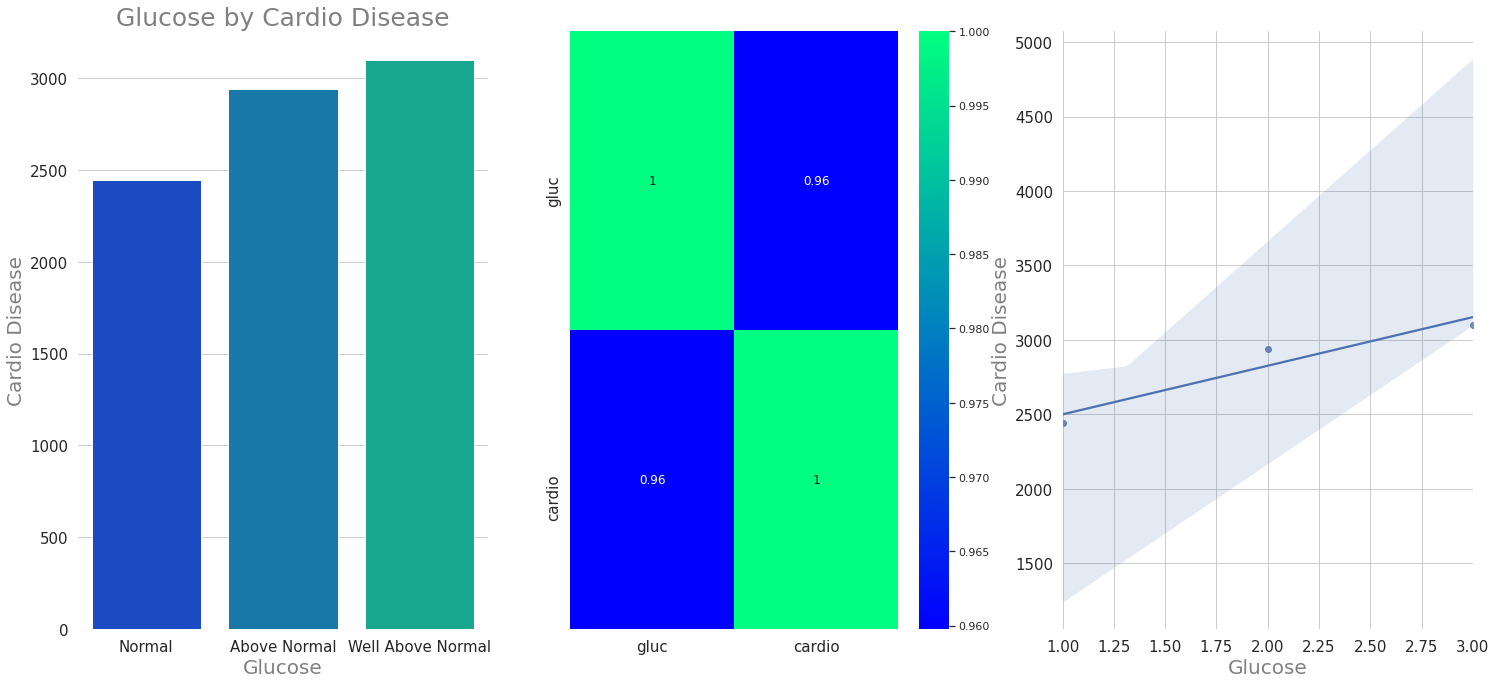

In [309]:
aux1 = df4[df4['gluc'] == 1].sample(5000, replace=False)
aux2 = df4[df4['gluc'] == 2].sample(5000, replace=False)
aux3 = df4[df4['gluc'] == 3].sample(5000, replace=False)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'gluc']].groupby(['gluc']).sum().reset_index()
        
plt.subplot(131)
sns.barplot( x = 'gluc', y = 'cardio', data = aux5, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Glucose by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Glucose", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Above Normal', 'Well Above Normal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'gluc', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Glucose", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### True Hypothesis, the correlation is very strong (0.95)

### 4.3.7 H7 - People who smoke have more cardiovascular diseases

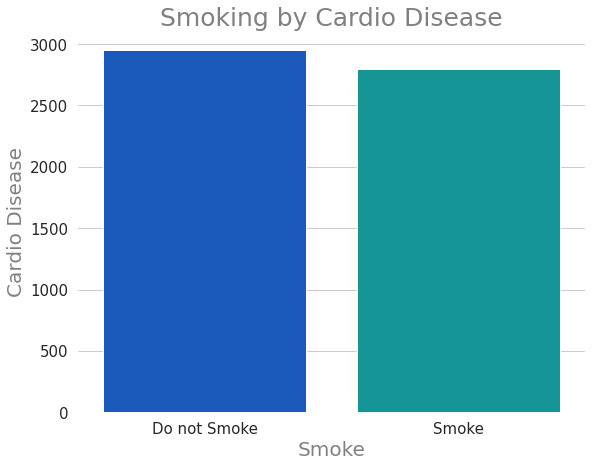

In [310]:
aux1 = df4[df4['smoke'] == 0].sample(6000, replace=False)
aux2 = df4[df4['smoke'] == 1].sample(6000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'smoke']].groupby(['smoke']).sum().reset_index()

plt.figure(figsize(20,7))
plt.subplot(121)
sns.barplot( x = 'smoke', y = 'cardio', data = aux4, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Smoking by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Smoke", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Do not Smoke', 'Smoke'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, but the difference is minimal

### 4.3.8 H8 - People who drink alcohol have more cardiovascular diseases

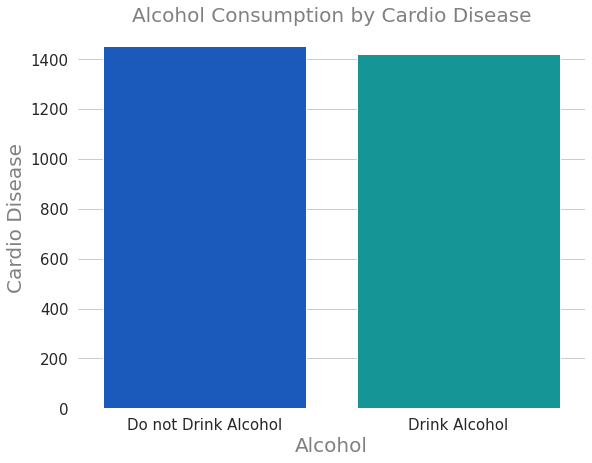

In [311]:
aux1 = df4[df4['alco'] == 0].sample(3000, replace=False)
aux2 = df4[df4['alco'] == 1].sample(3000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'alco']].groupby(['alco']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'alco', y = 'cardio', data = aux4, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Alcohol Consumption by Cardio Disease', size = 20, color = 'gray')
plt.xlabel("Alcohol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Do not Drink Alcohol', 'Drink Alcohol'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, but the difference is minimal

### 4.3.9 H9 - Sedentary people have more cardiovascular diseasess

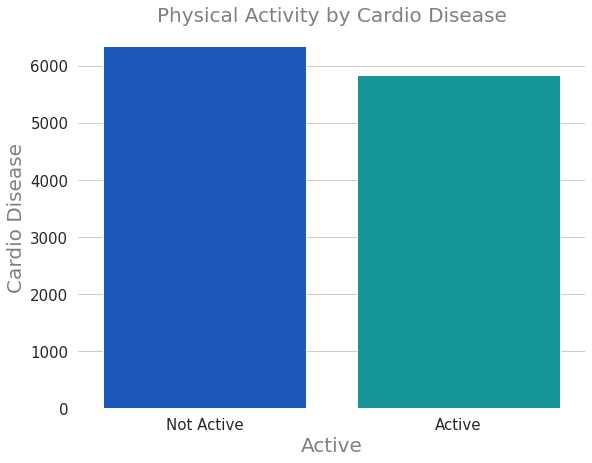

In [312]:
aux1 = df4[df4['active'] == 0].sample(12000, replace=False)
aux2 = df4[df4['active'] == 1].sample(12000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'active']].groupby(['active']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'active', y = 'cardio', data = aux4, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Physical Activity by Cardio Disease', size = 20, color = 'gray')
plt.xlabel("Active", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Not Active', 'Active'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, but the difference is minimal

### 4.3.10 H10 - People with higher BMI have more cardiovascular diseases

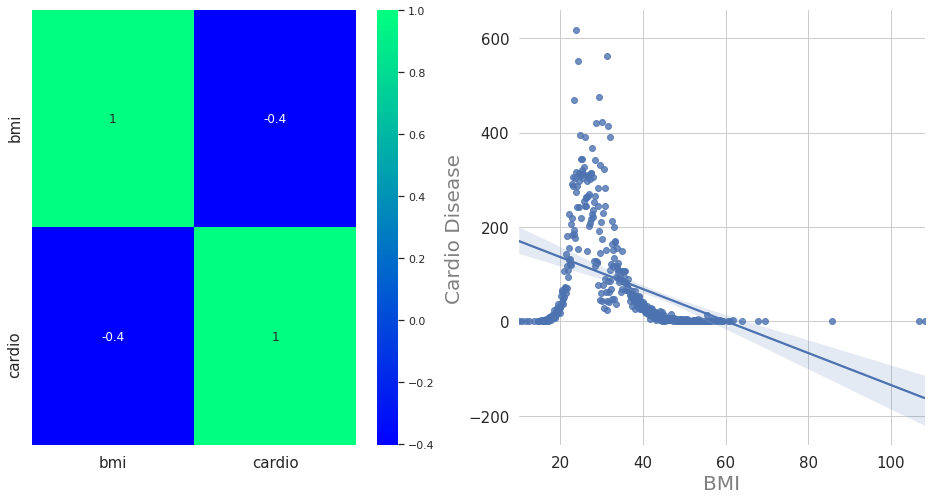

In [313]:
aux = df4[df4['cardio']==1][['cardio', 'bmi']].groupby(['bmi']).sum().reset_index()

plt.figure(figsize(16,8))
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'bmi', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("BMI", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### False hypothesis, the correlation is moderate negative, but data is not linear

### 4.3.10 H11 People with higher Risk Scale of CVD have more cardiovascular diseases

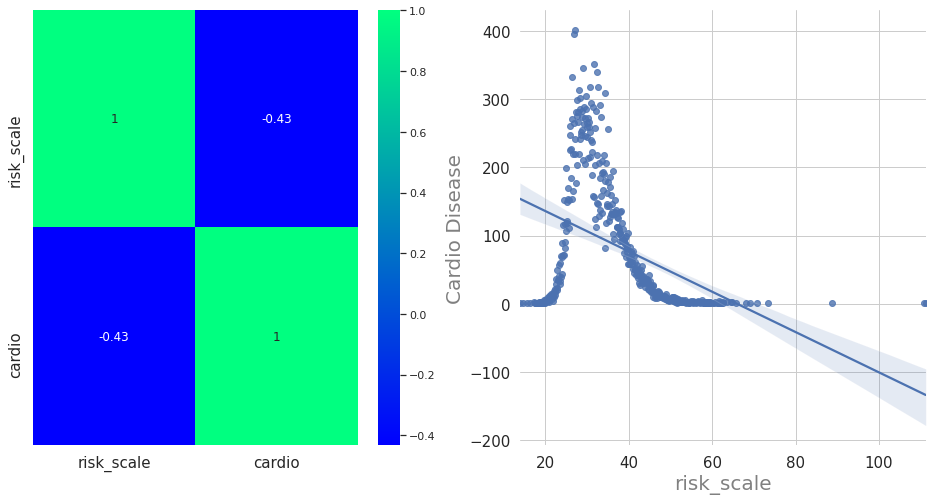

In [314]:
aux = df4[df4['cardio']==1][['cardio', 'risk_scale']].groupby(['risk_scale']).sum().reset_index()
        
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'risk_scale', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("risk_scale", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### False hypothesis, the correlation is moderate negative, but data is not linear

## 4.3 Multivariate Analysis

### 4.3.1 Correltion among Numerical Variables

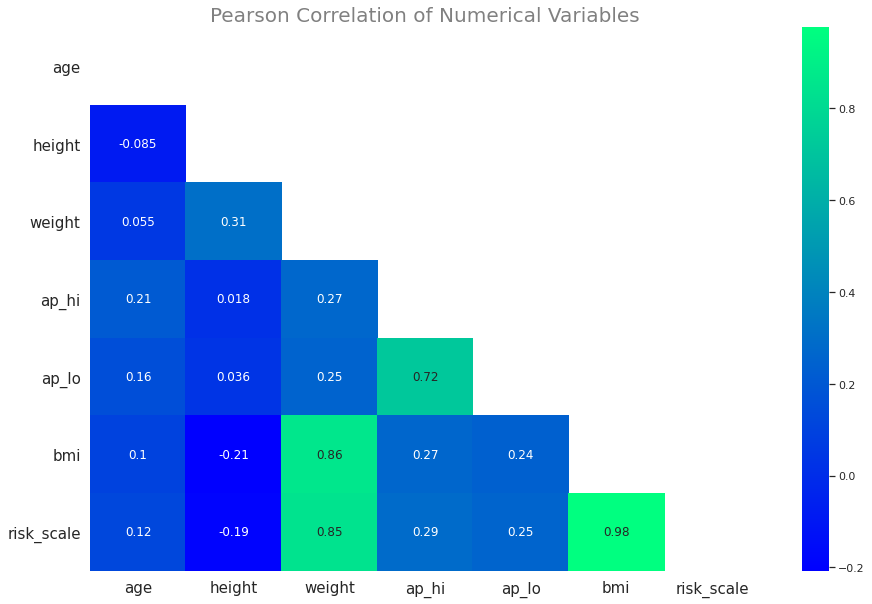

In [395]:
# Pearson Correlation
corr = num_var.corr( method = 'pearson' )

# Creating a with mask for the superior triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    # Creating the chart with mask
    plt.figure(figsize(15,10))
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = 'winter')
    plt.xticks(size = 15)
    plt.yticks(size = 15, rotation = 360)
    plt.title("Pearson Correlation of Numerical Variables", size=20, color='gray');

### Key points:

#### The strongest positive correlations are between:

##### bmi x risk_scale (0.98),
##### weight x bmi (0.86)
##### weight x risk_scale (0.85)
##### ap_hi x ap_lo (0.69). 

### 4.3.2 Correlation among Numerical and Binary Variables

In [316]:
num_var.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'risk_scale'], dtype='object')

In [317]:
bin_var.columns

Index(['gender', 'smoke', 'alco', 'active'], dtype='object')

In [318]:
#  All possible combinations
x1 = pointbiserialr(bin_var['gender'], num_var['age'])[0]
x2 = pointbiserialr(bin_var['gender'], num_var['height'])[0]
x3 = pointbiserialr(bin_var['gender'], num_var['weight'])[0]
x4 = pointbiserialr(bin_var['gender'], num_var['ap_hi'])[0]
x5 = pointbiserialr(bin_var['gender'], num_var['ap_lo'])[0]
x6 = pointbiserialr(bin_var['gender'], num_var['bmi'])[0]
x7 = pointbiserialr(bin_var['gender'], num_var['risk_scale'])[0]

x8 = pointbiserialr(bin_var['smoke'], num_var['age'])[0]
x9 = pointbiserialr(bin_var['smoke'], num_var['height'])[0]
x10 = pointbiserialr(bin_var['smoke'], num_var['weight'])[0]
x11 = pointbiserialr(bin_var['smoke'], num_var['ap_hi'])[0]
x12 = pointbiserialr(bin_var['smoke'], num_var['ap_lo'])[0]
x13 = pointbiserialr(bin_var['smoke'], num_var['bmi'])[0]
x14 = pointbiserialr(bin_var['smoke'], num_var['risk_scale'])[0]

x15 = pointbiserialr(bin_var['alco'], num_var['age'])[0]
x16 = pointbiserialr(bin_var['alco'], num_var['height'])[0]
x17 = pointbiserialr(bin_var['alco'], num_var['weight'])[0]
x18 = pointbiserialr(bin_var['alco'], num_var['ap_hi'])[0]
x19 = pointbiserialr(bin_var['alco'], num_var['ap_lo'])[0]
x20 = pointbiserialr(bin_var['alco'], num_var['bmi'])[0]
x21 = pointbiserialr(bin_var['alco'], num_var['risk_scale'])[0]

x22 = pointbiserialr(bin_var['active'], num_var['age'])[0]
x23 = pointbiserialr(bin_var['active'], num_var['height'])[0]
x24 = pointbiserialr(bin_var['active'], num_var['weight'])[0]
x25 = pointbiserialr(bin_var['active'], num_var['ap_hi'])[0]
x26 = pointbiserialr(bin_var['active'], num_var['ap_lo'])[0]
x27 = pointbiserialr(bin_var['active'], num_var['bmi'])[0]
x28 = pointbiserialr(bin_var['active'], num_var['risk_scale'])[0]

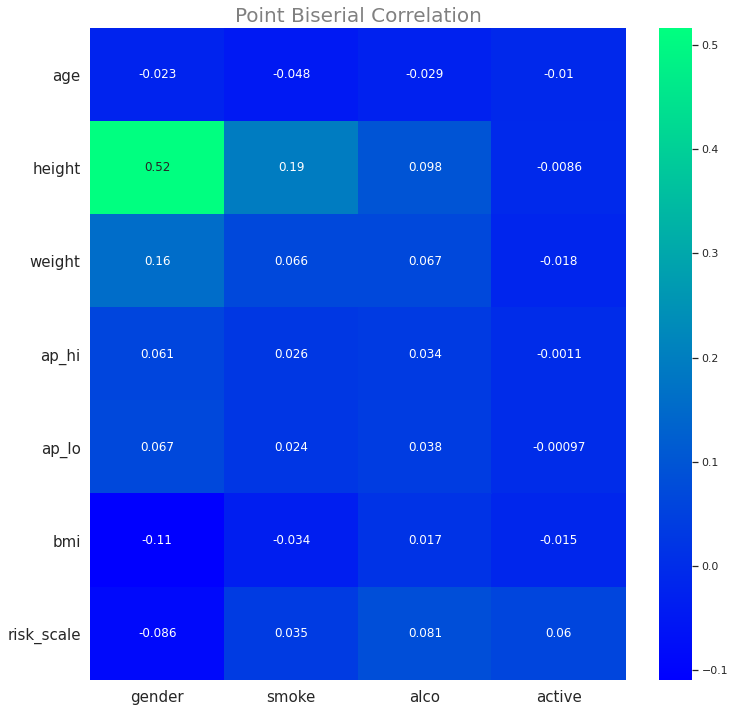

In [388]:
# Creating a DataFrame
dfx = pd.DataFrame({'gender':[x1, x2, x3, x4, x5, x6, x7],
                    'smoke':[x8, x9, x10, x11, x12, x13, x14],
                    'alco':[x15, x16, x17, x18, x19, x20, x21],
                    'active':[x22, x23, x24, x25, x26, x27, x28]})

# Sets the index equal to columns
dfx = dfx.set_index(num_var.columns)

# Heatmap
plt.figure(figsize(12,12))
sns.heatmap(dfx, annot=True, annot_kws={"fontsize":12}, cmap='winter')
plt.xticks(size = 15)
plt.yticks(size = 15, rotation = 360)
plt.title("Point Biserial Correlation", size=20, color='gray');

#### The only positive moderate correlation is betwenn gender x height (0.52)

## 4.3.3 Correlation among Categorical Variables

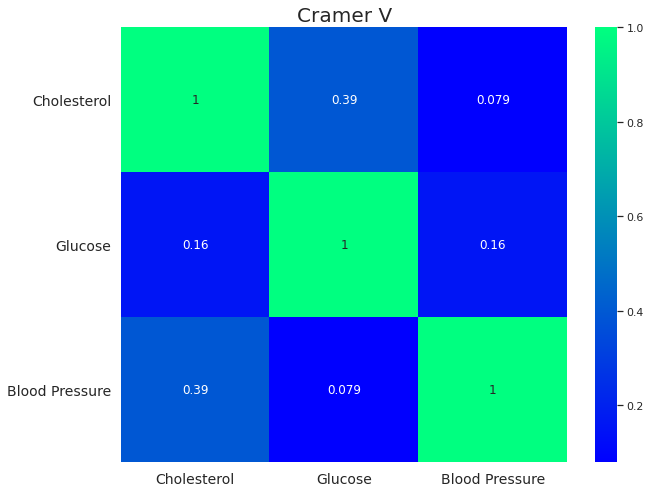

In [391]:
# Calculate Cramer V
a1 = cramer_v( df4['cholesterol'], df4['cholesterol'] )
a2 = cramer_v( df4['cholesterol'], df4['blood_pressure'] )
a3 = cramer_v( df4['cholesterol'], df4['gluc'] ) 

a4 = cramer_v( df4['gluc'], df4['gluc'] ) 
a5 = cramer_v( df4['gluc'], df4['blood_pressure'] )
a6 = cramer_v( df4['gluc'], df4['cholesterol'] )

a6 = cramer_v( df4['blood_pressure'], df4['gluc'] )
a7 = cramer_v( df4['blood_pressure'], df4['cholesterol'] )
a8 = cramer_v( df4['blood_pressure'], df4['blood_pressure'] ) 

# Final dataset
d = pd.DataFrame( {'Cholesterol': [a1, a2, a3], 
                   'Glucose': [a3, a4, a5],
                   'Blood Pressure': [a6, a7, a8]  })

d = d.set_index( d.columns )

plt.figure(figsize(10,8))
sns.heatmap( d, annot=True, cmap = 'winter' )
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 360)
plt.title('Cramer V', size=20);

# 4.4 Hypothesis List Answered

### H1 - Older people have more cardiovascular disease - True
### H2 - Smaller people have more cardiovascular diseases - True
### H3 - Men have more cardiovascular diseases - True
### H4 - People with higher blood pressure have more cardiovascular diseases - True
### H5 - People with higher cholesterol have more cardiovascular diseases - True
### H6 - People with higher glucose have more cardiovascular diseases - True
### H7 - People who smoke have more cardiovascular diseases - False
### H8 - People who drink alcohol have more cardiovascular diseases - False
### H9 - Sedentary people have more cardiovascular diseases - False
### H10 - People with higher BMI have more cardiovascular diseases - False
### H11 People with higher Risk Scale of CVD have more cardiovascular diseases - False

### Obs: These conclusions must be taken cautiously, once it was made samples of the dataset in a try to observe if they reflect the findings of scientific research (that's why simple hypothesis were made). To really understand the dataset these samples must be ignored and the analysis must be made considering all data and its imbalance.

# 5.0 Data preparation

In [320]:
df5 = df4.copy()

In [321]:
df5.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,50,55,51,48,47
gender,2,1,1,2,1
height,168,156,165,169,156
weight,62,85,64,82,56
ap_hi,110,140,130,150,100
ap_lo,80,90,70,100,60
cholesterol,1,3,3,1,1
gluc,1,1,1,1,1
smoke,0,0,0,0,0


In [322]:
# Drop Categorical columns
df5.drop(['bmi_status', 'blood_pressure_status'], axis=1, inplace=True)

## 5.1 Reescaling

There is a necessity of reesclaing data because they vary a lot. It was chosen Robust Scaler

In [323]:
# Robust scaler: weight, bmi
rs = RobustScaler()

# age
df5['age'] = rs.fit_transform(df5[['age']].values)

# height
df5['height'] = rs.fit_transform(df5[['height']].values)

# weight
df5['weight'] = rs.fit_transform(df5[['weight']].values)

# bmi
df5['bmi'] = rs.fit_transform(df5[['bmi']].values)

# ap_hi
df5['ap_hi'] = rs.fit_transform(df5[['ap_hi']].values)

# ap_lo
df5['ap_lo'] = rs.fit_transform(df5[['ap_lo']].values)

# blood_pressure
df5['blood_pressure'] = rs.fit_transform(df5[['blood_pressure']].values)

# risk_scale
df5['risk_scale'] = rs.fit_transform(df5[['risk_scale']].values)

In [324]:
df5.head().T

,0,1,2,3,4
id,0.000000,1.000000,2.000000,3.000000,4.000000
age,-0.300000,0.200000,-0.200000,-0.500000,-0.600000
gender,2.000000,1.000000,1.000000,2.000000,1.000000
height,0.272727,-0.818182,0.000000,0.363636,-0.818182
weight,-0.588235,0.764706,-0.470588,0.588235,-0.941176
ap_hi,-0.500000,1.000000,0.500000,1.500000,-1.000000
ap_lo,0.000000,1.000000,-1.000000,2.000000,-2.000000
cholesterol,1.000000,3.000000,3.000000,1.000000,1.000000
gluc,1.000000,1.000000,1.000000,1.000000,1.000000
smoke,0.000000,0.000000,0.000000,0.000000,0.000000


# 6.0 Feature Selection

In [325]:
df6 = df5.copy()

## 6.1 Split into X and Y

In [326]:
X = df6.drop(['cardio', 'id'], axis=1).copy()
y = df6[['cardio']].copy()

## 6.2 Random Forest Feature Selection

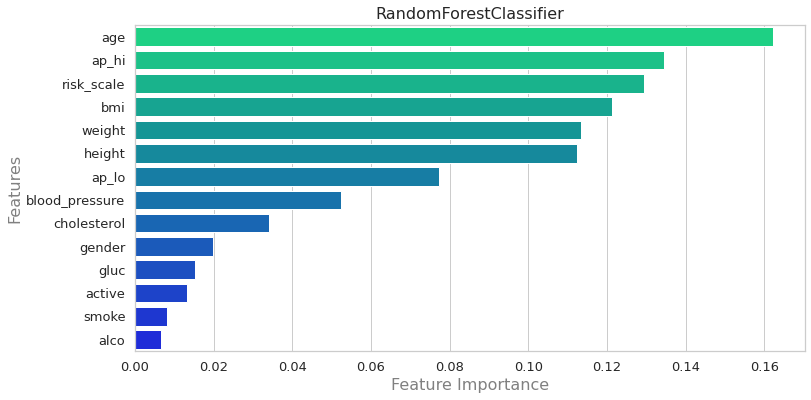

In [327]:
feature_selection(RandomForestClassifier(random_state=28), X, y)

## 6.3 Balanced Random Forest Feature Selection

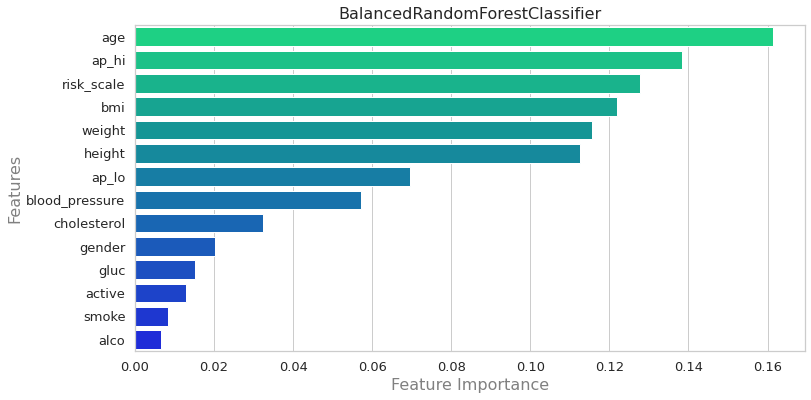

In [328]:
feature_selection(BalancedRandomForestClassifier(random_state=28), X, y)

## 6.4 CatBoost Classifier Feature Selection

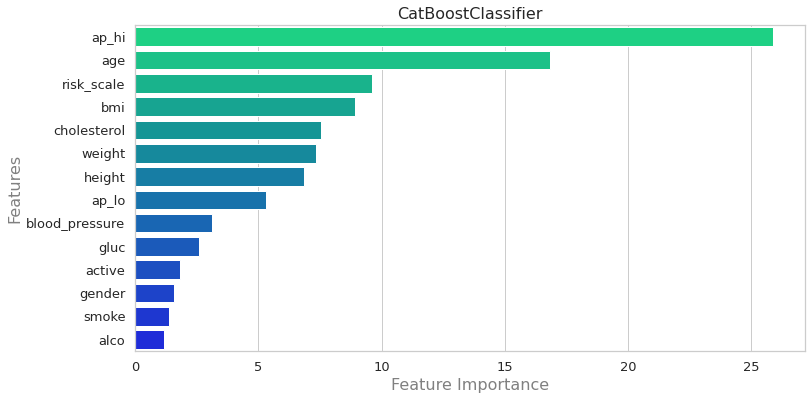

In [329]:
feature_selection(CatBoostClassifier(random_state=28, verbose=False), X, y)

## 6.5 XGBoost Classifier Feature Selection

[17:01:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


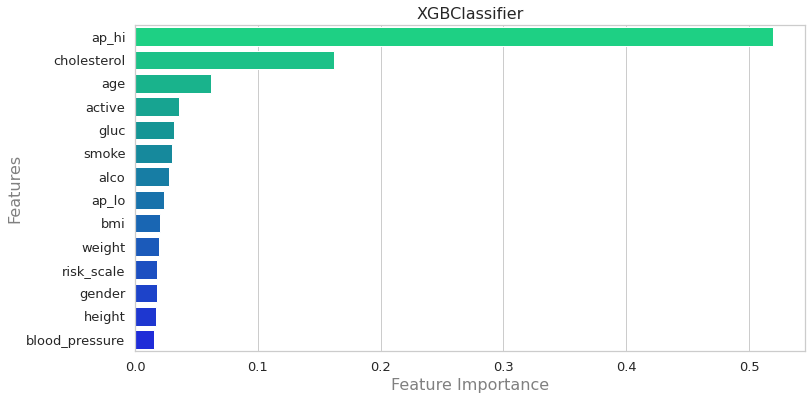

In [330]:
feature_selection(XGBClassifier(random_state=28), X, y)

## 6.6 LGBM Classifier Feature Selection

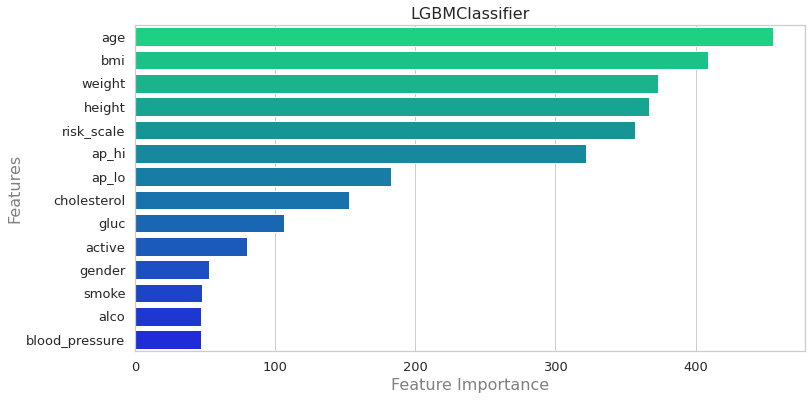

In [331]:
feature_selection(LGBMClassifier(random_state=28, n_jobs=-1), X, y)

## 6.7 Boruta Feature Selection

In [332]:
# Using Classifiers with all CPU cores
rf = RandomForestClassifier(n_jobs=-1)
extra = ExtraTreesClassifier(n_jobs=-1)

In [333]:
# Boruta using Random Forest Regressor
boruta = BorutaPy(rf, n_estimators='auto', verbose=False, random_state=23).fit(X.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'ap_hi', 'risk_scale']

In [334]:
# Boruta using Extra Trees Classifier
boruta = BorutaPy(extra, n_estimators='auto', verbose=False, random_state=23).fit(X.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'weight', 'ap_hi', 'bmi', 'blood_pressure', 'risk_scale']

# 7.0 Machine Learning

In [335]:
# selected columns
X = df6.drop(['cardio', 'id', 'alco', 'smoke', 'active'], axis=1).copy()
y = df6[['cardio']].copy()

# save
pickle.dump( X, open( 'data\X.pkl', 'wb' ) )
pickle.dump( y, open( 'data\y.pkl', 'wb' ) )

## 7.1 Split into train (70%), validation (10%) and test (20%)

In [336]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28, stratify=y)

# train valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=28)

# check balance of classes (0, 1) among y_train, y_test and y_valid
print(f"Class size for y_train dataset: {np.bincount(y_train['cardio'])}")
print(f"Class size for y_test dataset: {np.bincount(y_test['cardio'])}")
print(f"Class size for y_valid dataset: {np.bincount(y_valid['cardio'])}")

# columns and lines
print(f'X_train dataset: {X_train.shape[0]} columns, {X_train.shape[1]} rows')
print(f'y_train dataset: {y_train.shape[0]} rows')
print(f'X_valid dataset: {X_valid.shape[0]} columns, {X_valid.shape[1]} rows')
print(f'y_valid dataset: {y_valid.shape[0]} rows')
print(f'X_test dataset: {X_test.shape[0]} columns, {X_test.shape[1]} rows')
print(f'y_test dataset: {y_test.shape[0]} rows')

Class size for y_train dataset: [24948 24431]
Class size for y_test dataset: [6938 6779]
Class size for y_valid dataset: [2803 2684]
X_train dataset: 49379 columns, 11 rows
y_train dataset: 49379 rows
X_valid dataset: 5487 columns, 11 rows
y_valid dataset: 5487 rows
X_test dataset: 13717 columns, 11 rows
y_test dataset: 13717 rows


In [249]:
## Saving all data
pickle.dump( X_train, open( 'data\X_train.pkl', 'wb' ) )
pickle.dump( X_test, open( 'data\X_test.pkl', 'wb' ) )
pickle.dump( X_valid, open( 'data\X_valid.pkl', 'wb' ) )

pickle.dump( y_train, open( 'data\y_train.pkl', 'wb' ) )
pickle.dump( y_test, open( 'data\y_test.pkl', 'wb' ) )
pickle.dump( y_valid, open( 'data\y_valid.pkl', 'wb' ) )

## 7.2 Machine Learning Classifiers

In [264]:
# algorithms
models = [CatBoostClassifier(random_state=28, verbose=False),
          XGBClassifier(random_state=28),
          LGBMClassifier(random_state=28, n_jobs=-1),
          LogisticRegression(max_iter=220, random_state=28),
          RandomForestClassifier(random_state=28),
          BalancedRandomForestClassifier(random_state=28),
          SGDClassifier(loss='log', random_state=28, n_jobs=-1)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.50)

Training CatBoostClassifier...
Training XGBClassifier...
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training SGDClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.7387,0.7528,0.6934,0.7219,0.7377,0.4762,0.2613
0,LGBMClassifier,0.7370,0.7497,0.6941,0.7208,0.7361,0.4730,0.2630
0,XGBClassifier,0.7323,0.7447,0.6889,0.7157,0.7314,0.4634,0.2677
0,SGDClassifier,0.7299,0.7410,0.6885,0.7138,0.7290,0.4587,0.2701
0,LogisticRegression,0.7319,0.7513,0.6755,0.7114,0.7307,0.4624,0.2681
0,BalancedRandomForestClassifier,0.7117,0.7042,0.7079,0.7061,0.7116,0.4232,0.2883
0,RandomForestClassifier,0.7073,0.7022,0.6975,0.6998,0.7071,0.4143,0.2927


## 7.3 Confusion Matrices of the Best ML Models

### 7.3.1 CatBoost Confusion Matrix 

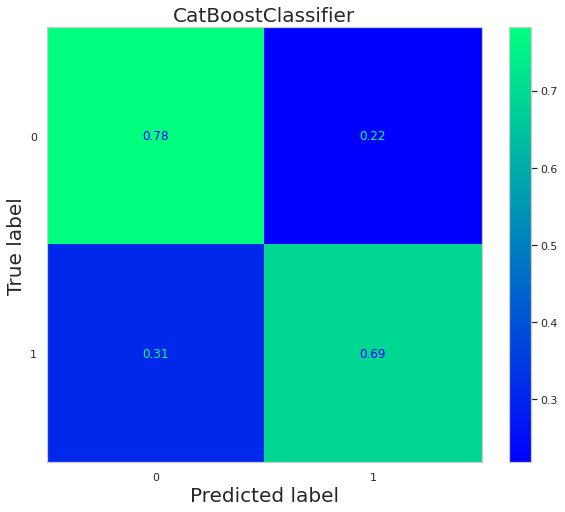

In [337]:
# Plot CatBoostClassifier Normalized Confusion Matrix
conf_matrix(CatBoostClassifier(random_state=28, verbose=False), X_train, y_train, X_valid, y_valid)

### 7.3.2 LGBM Confusion Matrix 

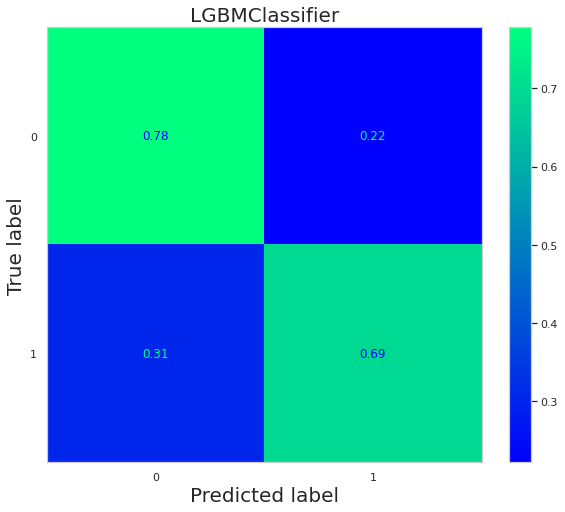

In [338]:
conf_matrix(LGBMClassifier(random_state=28, n_jobs=-1), X_train, y_train, X_valid, y_valid)

### 7.3.3 XGBoost Confusion Matrix 

[17:02:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


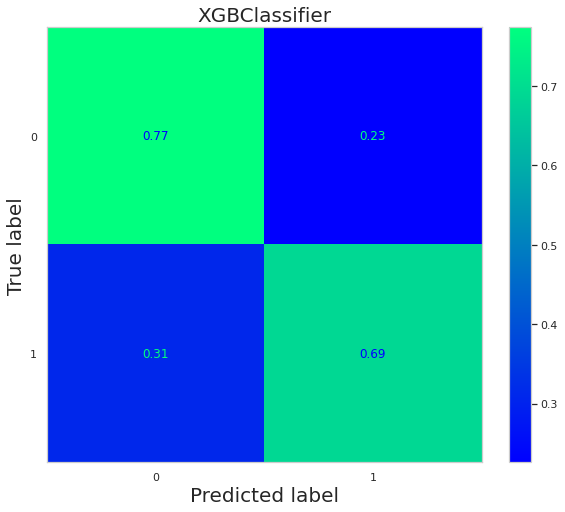

In [339]:
conf_matrix(XGBClassifier(random_state=28), X_train, y_train, X_valid, y_valid)

### According to the confusion matrices LGBM and CatBoost are better predictors.

## 7.4 Probability Distributions

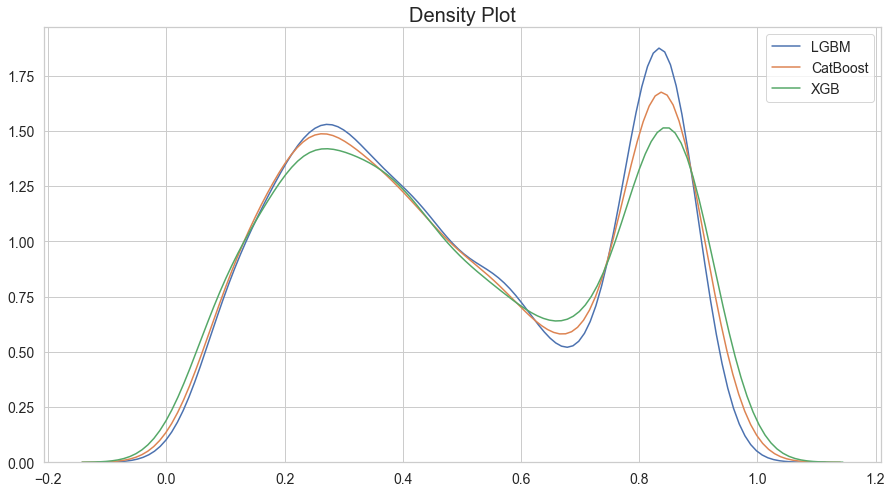

In [224]:
# models
cbc = CatBoostClassifier(random_state=28, verbose=False)
xgb = XGBClassifier(random_state=28)
lgbm = LGBMClassifier(random_state=28)

# model fit
cbc.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# positive probabilities only
prob_pred_lgbm = lgbm.predict_proba(X_valid)[:,1]
prob_pred_cbc = cbc.predict_proba(X_valid)[:,1]
prob_pred_xgb = xgb.predict_proba(X_valid)[:,1]

# sets the plot size
plt.figure(figsize=(15,8))
sns.kdeplot(prob_pred_lgbm, label='LGBM')
sns.kdeplot(prob_pred_cbc, label='CatBoost')
sns.kdeplot(prob_pred_xgb, label='XGB')
plt.title('Density Plot', fontsize=20)
plt.yticks(size=14)
plt.xticks(size=14)
plt.legend(prop={'size': 14})
plt.show();

### LGBM seems to be the best predictor

## 7.5 ROC Curve

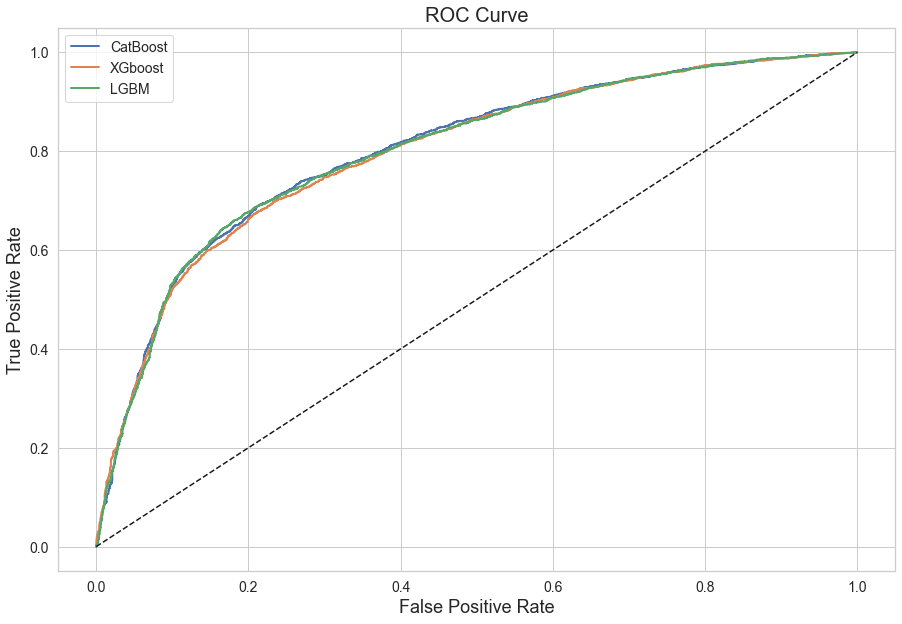

In [225]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(15, 10)

# calculate roc curves
cbc_fpr, cbc_tpr, _ = roc_curve(y_valid, prob_pred_cbc)
xgb_fpr, xgb_tpr, _ = roc_curve(y_valid, prob_pred_xgb)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_valid, prob_pred_lgbm)

# plot roc curve 
plt.plot(cbc_fpr, cbc_tpr, marker=',',linewidth=2, label='CatBoost')
plt.plot(xgb_fpr, xgb_tpr, marker=',',linewidth=2, label='XGboost')
plt.plot(lgbm_fpr, lgbm_tpr, marker=',',linewidth=2, label='LGBM')
plt.plot([0, 1], [0, 1], "k--") # dashed diagonal

# plot features
plt.title("ROC Curve", fontsize=20)
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.yticks(size=14)
plt.xticks(size=14)
plt.legend(prop={'size': 14})
plt.show();

## 7.6 Classification Report

In [226]:
# predictions
y_lgbm = lgbm.predict(X_valid)
y_cbc = cbc.predict(X_valid)
y_xgb = xgb.predict(X_valid)

# prints
print(type(lgbm).__name__)
print(classification_report(y_valid, y_lgbm))

print(type(cbc).__name__)
print(classification_report(y_valid, y_cbc))

print(type(xgb).__name__)
print(classification_report(y_valid, y_xgb))

LGBMClassifier
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2803
           1       0.75      0.69      0.72      2684

    accuracy                           0.74      5487
   macro avg       0.74      0.74      0.74      5487
weighted avg       0.74      0.74      0.74      5487

CatBoostClassifier
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2803
           1       0.75      0.69      0.72      2684

    accuracy                           0.74      5487
   macro avg       0.74      0.74      0.74      5487
weighted avg       0.74      0.74      0.74      5487

XGBClassifier
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      2803
           1       0.74      0.69      0.72      2684

    accuracy                           0.73      5487
   macro avg       0.73      0.73      0.73      5487
weighted avg       0.73   

### No significant differences were observed, but it was decided to discard XGBoost

## 7.7 Cross Validation of the Best Models

In [201]:
# load data
X_train = pickle.load(open ('data\X_train.pkl', 'rb'))
X_valid = pickle.load(open ('data\X_valid.pkl', 'rb'))
y_train = pickle.load(open ('data\y_train.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))

In [202]:
# concat
X = pd.concat([X_train, X_valid], axis = 0)
y = pd.concat([y_train, y_valid], axis = 0)

# cross validation
cv = StratifiedKFold(n_splits=12, random_state=28)

# define algorithms
models = [CatBoostClassifier(random_state=28, verbose=False),
          LGBMClassifier(random_state=28, n_jobs=-1)]
 
cross_validation(models, X, y, cv)

,Model Name,Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,CatBoostClassifier,0.7330 +/- %0.0077,0.7527 +/- %0.0077,0.6846 +/- %0.0116,0.7170 +/- %0.0090,0.7990 +/- %0.0071
0,LGBMClassifier,0.7333 +/- %0.0080,0.7543 +/- %0.0070,0.6826 +/- %0.0132,0.7166 +/- %0.0099,0.7989 +/- %0.0073


## 7.8 Best Thresholds 

### 7.8.1 Best Threshold LGBM

Best Threshold=0.4106063, F-Score=0.730


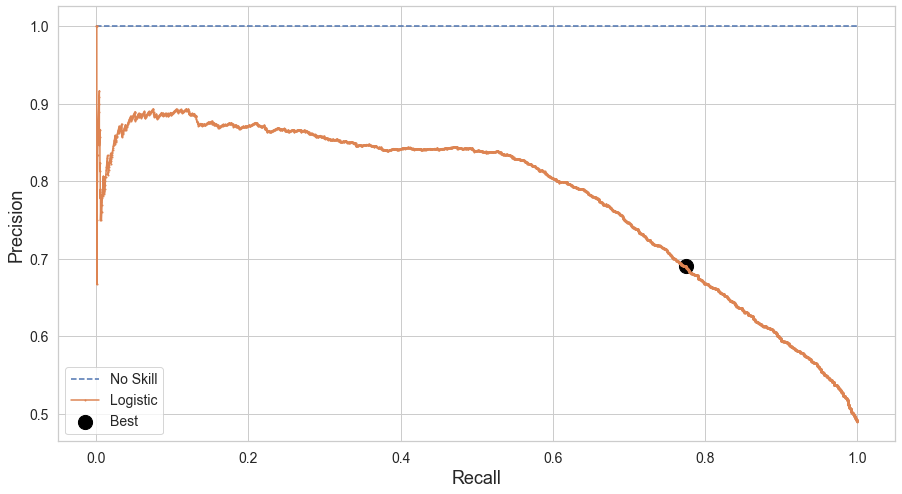

In [229]:
# model
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

# predict probabilities and get the positive outcome only
lgbm_yhat = lgbm.predict_proba(X_valid)

# keep probabilities for the positive outcome only
lgbm_yhat = lgbm_yhat[:, 1]

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_valid, lgbm_yhat)

# convert to f score
f1score = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(f1score)
print('Best Threshold=%f3, F-Score=%.3f' % (thresholds[ix], f1score[ix]))

# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.yticks(size=14)
plt.xticks(size=14)
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',  markersize=2, label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', s=200, color='black', label='Best')

# axis labels
plt.xlabel('Recall', size =18)
plt.ylabel('Precision', size = 18)
plt.legend(prop={'size': 14})

# show the plot
plt.show()

### 7.8.2 Best Threshold CatBoost

Best Threshold=0.4225983, F-Score=0.733


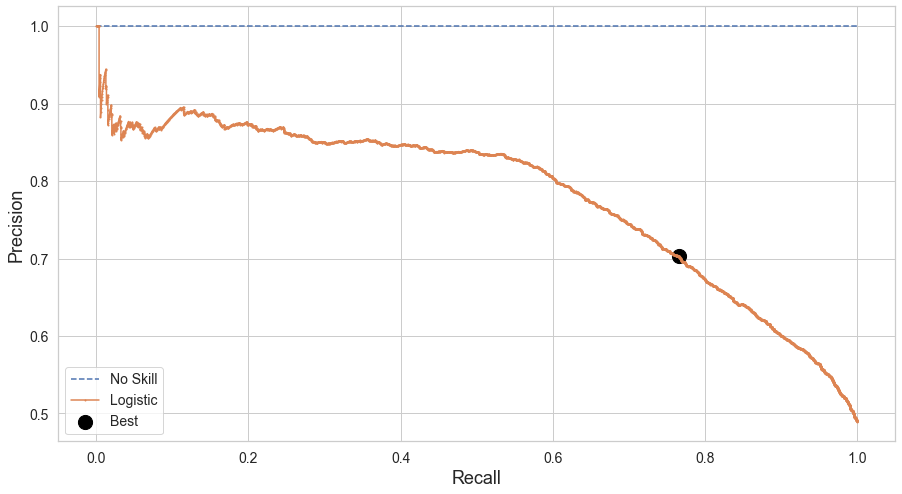

In [230]:
# model
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train, y_train)

# predict probabilities and get the positive outcome only
cbc_yhat = cbc.predict_proba(X_valid)

# keep probabilities for the positive outcome only
cbc_yhat = cbc_yhat[:, 1]

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_valid, cbc_yhat)

# convert to f score
f1score = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(f1score)
print('Best Threshold=%f3, F-Score=%.3f' % (thresholds[ix], f1score[ix]))

# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.yticks(size=14)
plt.xticks(size=14)
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',  markersize=2, label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', s=200, color='black', label='Best')

# axis labels
plt.xlabel('Recall', size =18)
plt.ylabel('Precision', size = 18)
plt.legend(prop={'size': 14})

# show the plot
plt.show()

## 7.9 Performance with best threshold 

In [238]:
# algorithm
models = [LGBMClassifier(random_state=28),
         CatBoostClassifier(random_state=28, verbose=False)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.41)

Training LGBMClassifier...
Training CatBoostClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.7217,0.6930,0.7738,0.7312,0.7228,0.4445,0.2783
0,LGBMClassifier,0.7192,0.6893,0.7753,0.7298,0.7203,0.4395,0.2808


In [239]:
# algorithm
models = [LGBMClassifier(random_state=28),
         CatBoostClassifier(random_state=28, verbose=False)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.42)

Training LGBMClassifier...
Training CatBoostClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.7250,0.700,0.7660,0.7315,0.7259,0.4508,0.2750
0,LGBMClassifier,0.7204,0.694,0.7664,0.7284,0.7214,0.4418,0.2796


# 8.0 Hyperparameter Fine Tuning

In [244]:
X_train = pickle.load( open( 'data\X_train.pkl', 'rb' ) )
y_train = pickle.load( open( 'data\y_train.pkl', 'rb' ) )

### 8.1 Bayes Search

In [255]:
#Using BayesSearchCV
cbc = CatBoostClassifier(random_state=28, verbose=False)
parameters = {'depth'         : [4,5,6,7,8,9,10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10,20,30,40,50,60,70,80,90,100]}

bayes_cbc = BayesSearchCV(estimator=cbc, search_spaces = parameters, cv = 2,  n_jobs=-1)
bayes_cbc.fit(X_train, y_train)

# Results from Grid Search
print(" Results from Bayes Search " )
print("\n The best estimator across ALL searched params:\n",bayes_cbc.best_estimator_)
print("\n The best score across ALL searched params:\n",bayes_cbc.best_score_)
print("\n The best parameters across ALL searched params:\n",bayes_cbc.best_params_)

Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7337734664533506

 The best parameters across ALL searched params:
 OrderedDict([('depth', 10), ('iterations', 100), ('learning_rate', 0.04)])


### 8.2 Grid Search

In [256]:
#Using gridSearchCV
cbc = CatBoostClassifier(random_state=28, verbose=False)
parameters = {'depth'         : [4,5,6,7,8,9,10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10,20,30,40,50,60,70,80,90,100]}

grid_cbc = GridSearchCV(estimator=cbc, param_grid = parameters, cv = 2,  n_jobs=-1)
grid_cbc.fit(X_train, y_train)

# Results from grid Search
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_cbc.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_cbc.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_cbc.best_params_)

Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7337733679143514

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 100, 'learning_rate': 0.04}


## 8.1 Tuned Model

In [258]:
# algorithm
models = [CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, random_state=28, verbose=False)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.42)

Training CatBoostClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.7272,0.7022,0.7679,0.7336,0.728,0.4552,0.2728


## 8.2 Cross Validation of Tuned Model

In [262]:
# concat
X = pd.concat([X_train, X_valid], axis = 0)
y = pd.concat([y_train, y_valid], axis = 0)

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=1)

# cross validation
cross_validation(models, X, y, cv)

,Model Name,Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,CatBoostClassifier,0.7337 +/- %0.0067,0.7572 +/- %0.0074,0.6789 +/- %0.0109,0.7159 +/- %0.0079,0.7998 +/- %0.0069


## 8.3 Confusion Matrix CatBoost Tuned

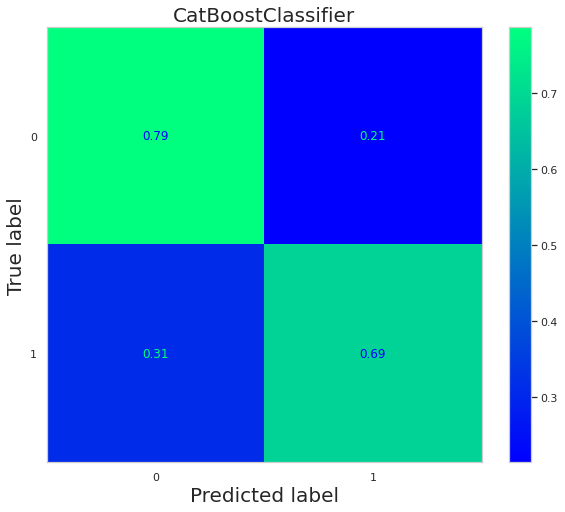

In [340]:
cbc = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, 
                          random_state=28, verbose=False)

conf_matrix(cbc, X_train, y_train, X_valid, y_valid)

# 9.0 CatBoost Calibration

In [263]:
# CatBoost Tuned
cbc_tuned = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, random_state=28, verbose=False)

# wrap the model
calibrated = CalibratedClassifierCV(cbc_tuned)

# define grid
param_grid = dict(cv=[2,3,4,5], method=['sigmoid','isotonic'])

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=28)

# define grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

# execute the grid search
grid_result = grid.fit(X_valid, y_valid)

# report the best configuration
print("Best F1-Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best F1-Score: 0.708637 using {'cv': 2, 'method': 'sigmoid'}
0.708637 (0.023828) with: {'cv': 2, 'method': 'sigmoid'}
0.699379 (0.025910) with: {'cv': 2, 'method': 'isotonic'}
0.706324 (0.024954) with: {'cv': 3, 'method': 'sigmoid'}
0.698811 (0.027907) with: {'cv': 3, 'method': 'isotonic'}
0.707416 (0.023936) with: {'cv': 4, 'method': 'sigmoid'}
0.700986 (0.025224) with: {'cv': 4, 'method': 'isotonic'}
0.707758 (0.024627) with: {'cv': 5, 'method': 'sigmoid'}
0.701293 (0.025680) with: {'cv': 5, 'method': 'isotonic'}


### The calibration using sigmoid and isotonic methods do not resulted in any improvements

# 10.0 Performance in Test Dataset

In [4]:
# load X_train, y_train, X_test and y_test
X_test = pickle.load(open('data\X_test.pkl', 'rb'))
y_test = pickle.load(open('data\y_test.pkl', 'rb'))
X_train = pickle.load(open('data\X_train.pkl', 'rb'))
y_train = pickle.load(open('data\y_train.pkl', 'rb'))

## 10.1 Performance with Default Algorithm

In [273]:
# default algorithm
models = [CatBoostClassifier(random_state=28, verbose=False)]

ml_performance(models, X_train, y_train, X_test, y_test, 0.42)

Training CatBoostClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.7291,0.70948,0.76516,0.73627,0.72951,0.4586,0.2709


## 10.2 Performance with Tuned Algorithm

In [274]:
# tuned algorithm
models = [CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, random_state=28, verbose=False)]

ml_performance(models, X_train, y_train, X_test, y_test, 0.42)

Training CatBoostClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,CatBoostClassifier,0.73048,0.71296,0.76103,0.73621,0.73083,0.4613,0.26952


## 10.3 Confusion Matrix of Default Model

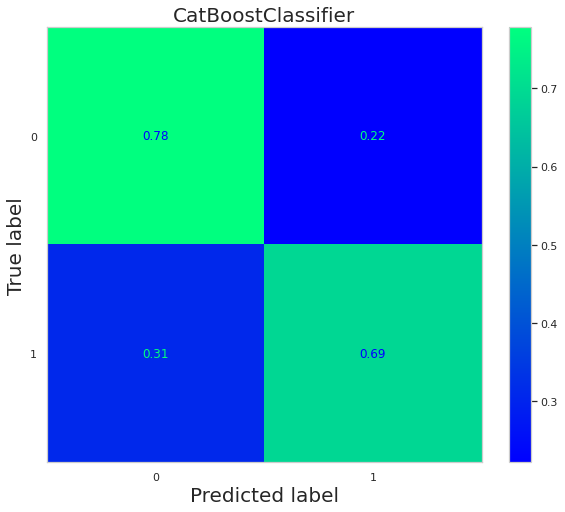

In [341]:
conf_matrix(CatBoostClassifier(random_state=28, verbose=False), X_train, y_train, X_test, y_test)

## 10.4 Confusion Matrix of Tuned Model

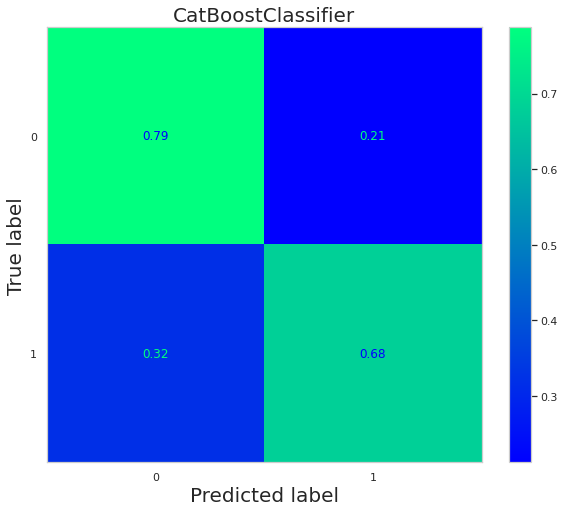

In [342]:
# Confusion Matrix of Tuned Model
cbc = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, 
                          random_state=28, verbose=False)

conf_matrix(cbc, X_train, y_train, X_test, y_test)

## 10.5 Cross Validation in Test Dataset - Default Model

In [5]:
# concat
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

# default model
models = [CatBoostClassifier(random_state=28, verbose=False)]

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=28)

# cross validation
cross_validation(models, X, y, cv)

,Model Name,Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,CatBoostClassifier,0.7337 +/- %0.0049,0.7522 +/- %0.0050,0.6884 +/- %0.0098,0.7188 +/- %0.0063,0.7993 +/- %0.0050


## 10.5 Cross Validation in Test Dataset - Tuned Model

In [6]:
# concat
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

# tuned model
models = [CatBoostClassifier(depth=10, iterations=100, learning_rate=0.04, random_state=28, verbose=False)]

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=28)

# cross validation
cross_validation(models, X, y, cv)

,Model Name,Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,CatBoostClassifier,0.7334 +/- %0.0050,0.7552 +/- %0.0051,0.6822 +/- %0.0098,0.7168 +/- %0.0064,0.8000 +/- %0.0046


# 11.0 Business Performance

The CatBoost classifier generated CVD forecasts with **average accuracy of 75.5%.** The entire data set has 70,000 patients. To calculate the profit generated by the model, the outcomes of the current solution (health software) were considered and compared with the model.

**Business issues:**
- For **1% increase** in precision the patient's bill increases **$100,00**
- The diagnosis cost is **\$1000,00 per patient**
- The precision rate of the current solution varies from **55% (worst scenario) to 65% (best scenario)**
- The precision rate of the machine learn model varies from **75.01% (worst scenario) to %76.03 (best scenario)**

*The business problem was formulated from the following website (Portuguese Brasil): https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

In [37]:
best_soft = (1500*70000)-(1000*70000)
worst_soft = (500*70000)-(1000*70000)
best_model = (2603*70000)-(1000*70000)
worst_model = (2501*70000)-(1000*70000)

results = pd.DataFrame({'Best Scenario': [best_soft, best_model], 'Worst Scenario': [worst_soft, worst_model]}, 
                       index=['Current Solution', 'Machine Learning Solution'])

results['Best Scenario'] = results['Best Scenario'].apply(lambda x: "${:,.2f}".format(x))
results['Worst Scenario'] = results['Worst Scenario'].apply(lambda x: "${:,.2f}".format(x))

increase = (((best_model - best_soft) / best_model)*100)
print(f'Increase of {increase:,.1f}% in revenues')

results

Increase of 68.8% in revenues


,Best Scenario,Worst Scenario
Current Solution,"$35,000,000.00","$-35,000,000.00"
Machine Learning Solution,"$112,210,000.00","$105,070,000.00"


The current solution (health software) can generate a terrible outcome of **\$35 million debt.** **Even in the worst scenario the Machine Learning Model will never generate a debt.** In that case, the outcome still remains positive, resulting in a **profit of $105 million**. 
 

Compared to the current solution the Machine Learning model is capable of **increase revenues in 68.8\%.**